In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [3]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [143]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])
days = days/np.max(days)

In [123]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
L_true = 1.0

In [6]:
# adapted code from http://code.activestate.com/recipes/189971-basic-linear-algebra-matrix/
def minor(matrix, i, j):
    #input should be numpy matrix
    matrix = np.asarray(matrix)
    m = np.zeros((matrix.shape[0]-1, matrix.shape[1]-1))
    m = np.matrix(m)
    # loop through the matrix, skipping over the row and column specified by i and j
    minor_row = minor_col = 0
    for row in range(matrix.shape[0]):
        if not row == i: # skip row i
            for col in range(matrix.shape[1]):
                if not col == j: # skip column j
                    m[(minor_row, minor_col)] = matrix[(row, col)]
                    minor_col += 1
            minor_col = 0
            minor_row += 1
    return m

In [144]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
#     a2 = 1.0 - a1
    BN_lim = 200
    #number in variable name is the gaussian j
    m = 0
#     delty1_true = 0.0
#     delty2_true = 0.3
#     sigsq1_true = .01
#     sigsq2_true = .04
    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.matmul(y-y_mod1, (y-y_mod1).T)
#     print(chisq1)
#     print(delty1/sigsq1)
    chisq2 = (1/sigsq2) * np.matmul(y-y_mod2, (y-y_mod2).T)
    if chisq1 > BN_lim:
        chisq1 = BN_lim
    if chisq2 > BN_lim:
        chisq2 = BN_lim
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]
#     print(H)
    beta1 = -2.0*np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -2.0*np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.matmul(temp_y-temp_y_mod1, (temp_y-temp_y_mod1).T)
        minor_chisq2 = sigsq2 * np.matmul(temp_y-temp_y_mod2, (temp_y-temp_y_mod2).T)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    
    #calc optimal lambda
    full_a = np.array([[a1, a2],]*len(x))
    full_H = np.array([H,]*len(x))
    N = np.multiply(np.divide(M,full_a),full_H)
    NxH = np.matmul(np.matrix(N), np.matrix(H).T)
    lambda_star = -0.5*np.sum(np.divide(NxH,MxH))
    print(lambda_star)
#     if np.any(MxH)<= 0:
#         print(MxH)
#         exit()
    return np.log(MxH).sum() + L*(a1+a2-1)

In [110]:
lnlike((0.00, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0), days, planets_etamb)

-2.04976186279e-41


-54302.439829837109

In [34]:
print(np.exp(-200))
print(np.finfo(np.float64).eps)

1.38389652674e-87
2.22044604925e-16


In [22]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, sigsq1_true, sigsq2_true, a1_true, a2_true, L_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml, a2_ml, L_ml = result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [23]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml)

0.0 0.5 0.0 0.3 0.01 0.04 0.5


In [145]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    if 0.0 < b < 1.0 and delty2 > 0.0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and L > 0.0:
#         pri_m = norm.logpdf(m, 0.0, .01)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = norm.logpdf(a1, 0.5, .5/3.0)
        pri_a2 = norm.logpdf(a2, 0.5, .5/3.0)
        pri_L = norm.logpdf(L, -2.04976186279e-41, 10**-5)
        return pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1 + pri_a2 + pri_L
    return -np.inf

In [146]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [147]:
ndim, nwalkers = 9, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.00001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0] for i in range(nwalkers)]

In [148]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

-1.8466812173e-37
-1.56424699126e-37
-1.39766723091e-37
-1.49653058669e-37
-1.28659082104e-37
-1.10413817381e-37
-1.07903759474e-37
-6.50175552256e-37
-1.90852021786e-37
-6.79146101574e-38
-2.64484132307e-37
-1.14881470252e-37
-1.78890683732e-37
-6.19504938336e-37
-5.36945073727e-38
-1.12212192572e-37
-4.31134571022e-37
-7.50516863751e-38
-2.52721146916e-37
-6.10497695476e-37
-7.51934654492e-38
-1.56382245776e-37
-2.90091194649e-37
-3.63350245863e-37
-1.08757815718e-37
-1.16916097325e-37
-5.25467984769e-37
-1.90628717606e-37
-1.67455855113e-37
-7.58535644309e-37
-1.01831645473e-37
-4.48447286913e-37
-1.24777501468e-37
-8.99255383412e-38
-3.3584868763e-37
-7.14880824711e-37
-2.06065109575e-37
-1.97015785317e-37
-8.03217327529e-38
-4.40671260451e-37
-1.44432033632e-37
-1.17312360178e-37
-2.20760090634e-37
-1.85484022516e-37
-2.78987825853e-37
-7.10637076565e-38
-1.37684500856e-37
-3.37842178961e-37
-1.41283573338e-37
-2.29406189128e-37
-3.6747138514e-37
-1.08829531275e-37
-6.53434044951e

-4.194303832e-38
-2.13834450455e-38
-1.48241883884e-37
-2.313729962e-38
-8.66087862089e-39
-1.00234710564e-38
-5.57354468322e-38
-1.43943815509e-37
-8.29023889808e-38
-5.50176455095e-38
-3.52145625421e-38
-9.28598888927e-38
-1.09487992017e-37
-2.33535269488e-38
-6.9312466058e-38
-6.34482132405e-38
-2.99967531782e-38
-2.73518688749e-38
-1.05973169348e-37
-7.0502097369e-38
-5.12411402253e-38
-1.5154195603e-38
-1.81520600232e-37
-6.03106421658e-38
-6.55801330453e-38
-5.24216669055e-38
-4.2193583596e-38
-2.69193263727e-38
-1.41463805858e-37
-2.36610582786e-38
-4.59999200736e-38
-1.60179789488e-38
-1.96339729139e-38
-1.40135059739e-37
-4.67748011129e-38
-1.12252665559e-37
-2.82881590691e-38
-7.33332131782e-38
-1.23749729609e-38
-8.84029600565e-38
-3.7262958017e-38
-6.13192548472e-38
-6.17439578363e-38
-8.41656822488e-38
-1.47117059317e-37
-1.80245321865e-37
-2.5186587986e-38
-8.64007958925e-38
-4.31821684592e-38
-2.83565213578e-38
-3.39163427341e-38
-5.65259754517e-38
-6.48903435203e-38
-1.

-5.73245411446e-39
-8.30733707298e-38
-1.93029884803e-38
-3.30341854952e-37
-9.80948133181e-38
-1.14699787254e-37
-4.06615443254e-38
-2.16920827549e-38
-1.42823720638e-38
-2.36879954741e-38
-1.16725787539e-37
-1.55924194653e-38
-5.24743598837e-38
-9.27105553522e-38
-8.9188430673e-38
-4.94873906181e-38
-8.66812719585e-38
-5.62139178013e-39
-2.07690353071e-38
-9.05773816957e-38
-7.95118292306e-37
-2.62003746152e-38
-2.17310880519e-38
-7.58131292272e-38
-8.18283569492e-38
-1.62533980269e-38
-1.20326809131e-37
-1.71650966069e-38
-4.0506209397e-38
-1.86522150638e-38
-2.91407155008e-38
-1.72479236211e-37
-3.09543358841e-38
-3.29072327067e-38
-1.71086003465e-37
-9.59093875414e-39
-1.08928061917e-37
-4.56618468272e-38
-1.7982899127e-38
-3.8935894092e-39
-1.70599205783e-38
-3.09154226673e-38
-4.29508302899e-38
-7.97514537218e-38
-5.99301755971e-38
-5.99203547282e-38
-3.12243416741e-38
-6.28518274481e-38
-6.54331786153e-38
-2.41363636675e-38
-5.76473312437e-39
-4.39992143167e-38
-6.48273465185e-

-9.53808466985e-38
-6.92714238555e-39
-4.03665063694e-38
-6.55399807363e-38
-3.52342683608e-38
-5.26093665311e-38
-4.24429284257e-38
-8.54450343461e-39
-2.49534690341e-39
-1.41340853052e-38
-6.76545575996e-38
-3.38453950492e-38
-3.96319155581e-38
-3.72629532306e-38
-7.35845617864e-38
-2.8679928208e-38
-4.91862193428e-39
-1.34148776505e-38
-9.58070437579e-39
-2.00906825987e-38
-4.72393093622e-39
-6.16160253009e-39
-1.01978217924e-37
-1.05729317756e-38
-8.24050660759e-38
-7.65110080916e-38
-6.24288111295e-39
-5.39037272847e-39
-3.02235391518e-38
-3.32813028693e-39
-7.91951017762e-38
-2.29337348635e-38
-1.89315067982e-38
-7.23559899065e-38
-7.75523131145e-38
-2.89602637437e-38
-2.33356168051e-38
-1.34060758147e-38
-7.40815416422e-38
-1.50416929856e-38
-1.41326957504e-38
-5.55732283125e-39
-3.63102348692e-39
-6.21888088008e-38
-1.26813330751e-38
-2.60089736803e-38
-3.51384683464e-39
-2.67375820687e-38
-7.83178112532e-38
-6.66826705618e-38
-1.44337052664e-37
-4.03200164233e-38
-1.5093298586

-9.34660306581e-38
-1.93866465806e-38
-2.08213180921e-38
-4.95764849405e-39
-1.3699859503e-38
-3.26581032965e-39
-1.03505823545e-39
-3.33744497217e-38
-1.23219153138e-38
-5.98301173016e-38
-1.75985935486e-39
-1.34790199136e-38
-2.69370595305e-38
-2.1778746971e-38
-6.01365715643e-39
-2.48247794279e-38
-1.04086819994e-38
-2.54188949192e-38
-5.47187964839e-38
-9.29675497329e-39
-1.26199414335e-37
-4.08993920779e-38
-2.97636330006e-39
-4.38671411064e-39
-5.01762381476e-39
-5.52877074435e-39
-4.25576979233e-39
-6.10308175294e-39
-1.89224952099e-39
-1.16649585619e-38
-3.41401282612e-38
-1.56623821568e-38
-1.09278966516e-37
-5.74054555308e-38
-3.93757004363e-39
-5.03313041053e-38
-7.37348299194e-39
-4.56476176822e-39
-6.62834761737e-39
-3.1058740473e-38
-2.94597906031e-38
-5.28133085322e-38
-1.58669460245e-38
-6.4234132655e-38
-6.02828026893e-39
-3.01875623056e-39
-1.06133345981e-38
-2.45390954886e-38
-3.02877389218e-39
-3.86335730551e-39
-2.3455039291e-38
-2.73041081621e-39
-1.36907135202e-3

-9.89157253117e-39
-5.33923813745e-39
-1.90588053173e-38
-2.63707119974e-39
-2.41857676396e-38
-3.27273971939e-39
-2.42872614497e-38
-9.26063463633e-39
-1.17939054013e-38
-5.41769284331e-38
-1.46339403675e-39
-3.69040965202e-39
-1.55586184896e-39
-5.47298710589e-38
-3.60109736798e-39
-1.12281936588e-38
-9.77855142167e-39
-7.64117263395e-38
-1.84344047552e-39
-1.09432491122e-38
-5.67878587469e-39
-4.88205327792e-39
-1.12766002417e-38
-7.32619687802e-39
-2.21500664999e-38
-1.3221750472e-38
-4.98031690856e-38
-7.27081902013e-39
-5.31376691386e-38
-4.23058952204e-39
-1.23816155152e-37
-1.62668758208e-39
-2.21810475246e-38
-2.23846769322e-39
-2.95701898493e-39
-3.78461031451e-39
-5.09108609878e-38
-2.31383502863e-39
-1.93264047376e-38
-3.03244956041e-38
-1.63454533232e-38
-2.53689488733e-38
-3.45155382939e-39
-2.23268004491e-38
-1.52604622235e-38
-3.48668225814e-38
-1.26540734608e-38
-2.01909106097e-38
-3.74090262848e-40
-5.30441108443e-39
-5.83822194e-39
-6.35299875863e-38
-1.22729216142e-

-4.1567413118e-38
-5.94091442163e-39
-3.08383698406e-38
-1.15828173391e-39
-1.85567880387e-40
-1.32723058597e-39
-3.9883115216e-39
-4.01872287781e-39
-5.89420497815e-39
-1.40103429285e-38
-1.1122612218e-38
-2.72859542222e-39
-3.52121139817e-38
-4.29507713629e-39
-2.94496958487e-37
-1.39342418816e-39
-3.17747845609e-38
-1.61262894278e-39
-1.20780213152e-38
-2.08611715505e-39
-2.4073967006e-39
-1.71157867401e-38
-6.55026690445e-38
-6.8316683529e-40
-5.68614456492e-39
-1.79445205053e-39
-2.22687945448e-38
-5.11477571212e-39
-1.60215446561e-39
-2.98495496197e-39
-3.73180272815e-38
-1.37185163496e-38
-2.18891447175e-39
-5.15445067621e-40
-1.13710969164e-39
-2.79490758224e-39
-1.65992043524e-39
-3.2581044907e-39
-2.04861072269e-39
-1.60997638159e-38
-8.20958133989e-39
-4.39354252692e-39
-3.1088739258e-38
-3.13739299108e-38
-1.68526934786e-39
-1.34171206882e-38
-7.83968028105e-40
-1.97089664796e-39
-3.22129728491e-39
-3.87916593034e-39
-7.01384310953e-39
-2.55217864955e-38
-4.53562931556e-40


-5.43334801772e-38
-9.87302033101e-40
-8.07038581001e-39
-3.18563452042e-39
-3.34537243048e-39
-9.41136765141e-39
-6.35095693474e-38
-1.52006886319e-39
-1.68757024705e-39
-3.69791337803e-39
-2.36132324288e-39
-1.44284011457e-38
-1.39838138793e-39
-1.28390150571e-38
-3.84262571171e-40
-1.20077692446e-38
-1.59483691518e-40
-1.49297721674e-39
-2.13427383923e-39
-1.14545757787e-39
-4.17301840983e-39
-6.12871570987e-40
-4.20868502606e-39
-1.74003076055e-39
-1.263607477e-39
-3.53094286813e-39
-6.22613264131e-39
-5.23814092595e-40
-1.93520180711e-39
-5.09582555528e-39
-3.22319044935e-38
-2.43983123237e-39
-8.30930702279e-40
-4.54449866169e-38
-1.97321774716e-39
-2.54113152322e-39
-2.81966805873e-39
-5.56741024866e-40
-7.76039483536e-39
-6.277655403e-39
-3.89923678704e-39
-2.53576262722e-40
-2.07581858995e-39
-4.33072810215e-39
-5.42172349565e-39
-1.32635447439e-40
-1.9938680325e-39
-1.1824261735e-38
-4.57352331919e-39
-4.02353379117e-39
-7.0846671621e-40
-1.19886776327e-39
-9.04277826419e-40


-3.28784256031e-39
-1.48630007446e-39
-6.84883846728e-39
-3.50162186652e-38
-2.08475510634e-39
-4.04610711806e-38
-5.12057170935e-40
-4.22280860467e-39
-8.64576642364e-40
-9.57793531682e-39
-2.87445136722e-39
-1.28820677229e-39
-2.40032166593e-39
-6.43918600639e-39
-2.17518982108e-39
-2.27018724481e-38
-1.83650892394e-40
-9.04960019766e-40
-9.53678845314e-40
-2.84228944029e-39
-3.36133965546e-39
-6.68658736418e-39
-3.59944209931e-39
-3.79035502394e-40
-3.67079730434e-40
-9.13523558893e-39
-5.20577751785e-39
-1.55905208242e-38
-2.66832107521e-39
-2.21884173737e-39
-5.06518404623e-40
-2.58031871641e-40
-8.14422991515e-40
-8.318319878e-40
-4.49763720294e-40
-2.40531699443e-39
-4.55525444993e-39
-5.59542349158e-40
-2.62470621159e-39
-8.99206674585e-39
-6.74113548618e-38
-9.68562801679e-40
-1.55245465118e-39
-9.23525758881e-40
-6.11990218901e-40
-3.7146299041e-39
-3.38223460963e-39
-5.74027440953e-40
-4.26063058298e-39
-2.02397557466e-39
-1.61916782611e-39
-6.54609757326e-38
-1.16633768979e

-7.42377534729e-39
-1.3409748814e-39
-1.99598482608e-40
-1.04827845755e-38
-4.1530269362e-39
-6.07703114412e-40
-5.7329550178e-40
-1.59982742149e-38
-1.45770699572e-39
-6.9084285375e-40
-6.57030908308e-40
-5.35155482465e-38
-2.51185188304e-39
-5.01427894791e-40
-3.22765145809e-40
-4.10230321084e-40
-7.41246475002e-40
-6.11984319425e-39
-2.20742971419e-39
-3.48587284604e-39
-9.51408395003e-40
-1.83935622548e-38
-1.14469755465e-40
-2.22775546346e-39
-1.25400701309e-39
-1.05242348642e-39
-4.86201981093e-40
-7.26971839544e-41
-3.3012528962e-39
-2.29938889291e-39
-2.10735221174e-40
-4.49427544348e-40
-8.22148987091e-40
-2.52964502317e-40
-1.69839828854e-39
-6.91129171848e-40
-1.75327394598e-39
-4.06662168677e-39
-4.44131264834e-40
-6.01392522739e-39
-7.22275693029e-40
-7.68434919108e-40
-9.05857498734e-40
-2.12286216104e-39
-3.15044363883e-40
-6.37662354446e-39
-3.35645376317e-39
-2.27129630755e-39
-3.30196190198e-39
-1.25846646936e-39
-4.5403689379e-40
-1.42033847946e-39
-1.60004948136e-39

-1.29089746991e-39
-3.08608587893e-39
-1.11726167339e-39
-1.21143727932e-39
-4.8191822847e-41
-3.66859427095e-39
-3.43442297738e-40
-3.41682463642e-40
-1.05990797169e-39
-2.04439446871e-40
-7.59919768089e-40
-5.47144289418e-40
-9.45530561903e-39
-3.02766395922e-39
-3.24986019231e-40
-1.4401398018e-40
-4.7610213719e-40
-1.87632513192e-40
-4.44835530663e-39
-8.71060635142e-40
-2.49943379534e-38
-2.31306759881e-40
-1.75805812044e-39
-1.30743223595e-41
-8.46438792533e-40
-3.90339288702e-40
-8.36922349457e-40
-1.04927149426e-39
-1.34552433624e-39
-1.62051479564e-40
-6.85907492016e-40
-2.09875629803e-40
-1.13467088633e-40
-1.32921493362e-39
-3.01666450514e-40
-1.25259428427e-40
-1.07886993619e-39
-1.8930764998e-39
-6.85513119866e-39
-2.83523541319e-39
-9.60423517715e-40
-9.51079449843e-41
-4.47152518837e-40
-1.13439606469e-40
-7.73558381754e-40
-1.1289054567e-40
-6.39477576184e-40
-3.74616306915e-39
-1.23806326637e-39
-1.4736706451e-39
-3.78495455565e-40
-2.00864453131e-40
-4.19208780603e-40

-3.62176050945e-40
-8.69065890639e-39
-4.04741682098e-40
-2.46455918859e-40
-1.03524536327e-39
-3.07546470591e-40
-6.77174583999e-40
-1.03811548802e-39
-8.37366149068e-40
-1.49301422915e-39
-3.08425066623e-40
-2.64660663044e-39
-1.61263795868e-40
-3.43799798846e-40
-6.28748240233e-40
-4.40062540001e-40
-1.07660461176e-40
-1.67639118207e-40
-4.69652749015e-39
-1.15091693025e-39
-1.050712807e-40
-2.6756526133e-39
-5.9549354793e-40
-9.62512276464e-40
-9.51132935906e-40
-1.01141440396e-39
-5.24864434765e-41
-2.38654252974e-40
-2.42908274675e-40
-5.52615058508e-40
-1.26781561819e-39
-8.42453019444e-39
-2.05895037356e-40
-7.32324068164e-41
-4.58484828864e-39
-8.20375702487e-40
-1.76102687752e-39
-3.1011516325e-40
-1.41401081159e-40
-9.25351603171e-40
-4.76773483165e-39
-2.37394105293e-39
-8.64562299061e-41
-9.37005368826e-41
-1.23660592962e-40
-2.25954914205e-39
-6.76336182994e-40
-9.56298322232e-41
-7.71730027951e-40
-1.08715786132e-39
-5.0471348728e-40
-9.90501662225e-40
-3.72444164363e-40

-1.36758032751e-40
-8.96774578056e-41
-1.012855521e-40
-1.18584374988e-39
-5.97242431159e-40
-1.26953890987e-39
-3.60884149031e-40
-2.11718215163e-40
-6.67920011865e-39
-5.27314860604e-39
-1.71408123536e-40
-1.69348799643e-40
-1.63155654372e-39
-3.48349054713e-41
-3.79843493816e-40
-1.00096121308e-39
-1.79227018418e-40
-3.57397818191e-40
-2.82423462816e-40
-9.60905929664e-40
-2.86510759331e-40
-1.61406397524e-41
-7.82098884713e-41
-3.39360131116e-40
-1.93641820868e-40
-2.79748264086e-41
-1.48729452308e-40
-3.3728225101e-41
-1.13635269896e-40
-1.76421133834e-40
-2.65795757191e-40
-9.68994177164e-41
-2.18131509129e-40
-1.4189281627e-40
-6.76113587173e-40
-1.4701938884e-41
-6.37822289616e-41
-2.4553832721e-40
-2.5553714568e-40
-1.75211512168e-39
-1.20224362099e-40
-9.12307198585e-41
-8.65605301354e-41
-1.31955730292e-40
-1.84316939498e-40
-5.95939492358e-40
-1.41555763982e-40
-3.11476830308e-40
-3.15403705934e-40
-6.01003929549e-40
-9.05040566919e-41
-3.62538212109e-40
-8.62797163981e-40


-3.64460866469e-40
-2.39104022628e-40
-9.37033240031e-41
-1.41915039649e-40
-2.94543001046e-40
-8.63905163553e-41
-1.74099637902e-40
-1.24898456821e-40
-1.85007254105e-40
-4.58625360778e-41
-5.5088914566e-41
-8.3185587232e-41
-3.29786449781e-40
-1.76639379514e-40
-1.25668563882e-40
-8.25806272615e-40
-3.98003216426e-40
-5.73905857522e-40
-1.5919535416e-40
-1.06967885764e-40
-1.32547690388e-40
-6.20025024929e-40
-6.51869312477e-41
-4.18888529202e-40
-4.799439594e-41
-1.98991666173e-40
-6.07238087467e-40
-1.65545813509e-41
-9.94248062174e-40
-1.10368566446e-40
-1.3604339618e-40
-3.72449992167e-40
-2.12803431099e-40
-3.98664985225e-41
-7.7140260518e-41
-1.87181045921e-40
-1.61139336933e-41
-2.81686871736e-41
-1.74398645279e-40
-4.88419865928e-41
-2.18212327682e-40
-2.30769334088e-40
-2.54974264028e-39
-9.58304575412e-41
-3.90299356788e-41
-1.27129324124e-40
-9.36240809346e-41
-6.55276226919e-40
-4.10435737319e-41
-1.94054329654e-40
-6.53112364653e-40
-5.54307850653e-41
-4.48260753481e-41


-1.78503514115e-40
-3.82219293586e-41
-1.39556397554e-40
-1.23766486876e-40
-1.65704778732e-40
-8.44976276028e-41
-3.5793502438e-41
-7.04748967149e-41
-4.97426324935e-41
-1.42772085719e-40
-1.36043372717e-40
-2.57164744316e-41
-1.52352087722e-40
-2.9137619012e-40
-3.09913103283e-40
-1.23301946689e-41
-7.05282762596e-41
-1.20211429073e-40
-1.45668559088e-40
-1.52912746387e-40
-1.79088565943e-41
-4.51975131046e-41
-2.13674337532e-40
-2.12825640383e-40
-1.52405853961e-41
-2.00823360311e-40
-1.49565426441e-40
-8.31626242401e-41
-2.50052211303e-41
-2.42081158019e-41
-1.55182688083e-40
-2.66268182838e-40
-3.78417751476e-41
-1.46328488118e-41
-1.5465532146e-40
-3.6108269429e-40
-4.30925564125e-40
-1.25069735464e-40
-1.08697780623e-40
-3.54374521787e-41
-4.30098968597e-40
-6.94992384e-41
-4.56045222507e-41
-1.03468168666e-40
-3.81075128751e-40
-1.14623137125e-40
-2.58961406138e-40
-1.83686142651e-40
-2.50528646065e-40
-7.32434906906e-41
-7.74929184778e-41
-9.4538575628e-41
-1.90930313589e-40
-

-8.2655850255e-41
-1.23726468572e-40
-6.7010978918e-41
-1.59469479173e-40
-1.62581723136e-40
-2.29655743246e-40
-1.12152693307e-40
-1.1932591946e-40
-8.02134309682e-41
-6.11978211667e-41
-4.30091608275e-41
-8.93226272901e-41
-5.93840816251e-41
-4.00745303902e-41
-1.37587254124e-41
-7.15893556868e-41
-1.52421158523e-41
-1.49672629956e-40
-9.1553302882e-41
-5.94208164748e-41
-3.48967007229e-41
-8.68428843942e-41
-1.36017359383e-40
-1.61060684183e-41
-3.47824536365e-41
-4.56304141096e-41
-6.26787445679e-41
-1.5218103844e-41
-1.13785751099e-40
-2.41845729235e-40
-7.44345840849e-41
-3.26817394181e-40
-2.58809189796e-41
-7.36655693183e-41
-1.02514741759e-40
-7.42641725621e-41
-1.06673033796e-40
-1.18543087737e-40
-5.1001504551e-41
-4.25219367008e-41
-2.25582204443e-40
-1.92759103551e-40
-1.67676542536e-40
-1.86334308788e-40
-5.37397120485e-41
-1.39817389365e-41
-3.15242576708e-41
-1.32352196344e-40
-2.483752883e-41
-4.75465560113e-41
-6.7470319671e-41
-4.62580915567e-41
-2.17121717757e-41
-2

-1.23567857877e-40
-2.92636292561e-40
-6.3510634768e-41
-1.1840354961e-41
-6.98007645724e-41
-3.78963528407e-41
-5.46970534272e-41
-4.91375849058e-41
-2.04121472779e-41
-1.56971972767e-41
-4.38395487694e-41
-1.15043105747e-40
-3.21228246193e-41
-2.58050695649e-41
-3.70095458476e-41
-3.12984831634e-41
-2.68521621055e-41
-1.1618967802e-40
-4.75851561424e-41
-2.4313786077e-41
-1.969877179e-40
-1.70617108462e-40
-7.22554305806e-41
-7.52214858502e-41
-8.59425874804e-41
-2.2557945105e-41
-1.23431235519e-41
-6.41278415117e-41
-3.59741908567e-41
-1.84056455528e-41
-3.55999474274e-41
-5.47148777829e-41
-5.18689733532e-41
-9.09145725488e-41
-4.80973456635e-41
-5.61360323329e-40
-7.93967506807e-41
-1.35787203978e-41
-2.66038826634e-41
-2.093028318e-41
-3.18678382628e-41
-8.95959626831e-41
-3.11337796004e-41
-3.23800520632e-41
-4.15490352315e-41
-4.40671956204e-41
-2.35351446869e-41
-2.86288698383e-41
-4.06037966633e-41
-2.66884769686e-41
-5.24474013616e-41
-4.12682432048e-41
-2.82051063486e-41
-5

-2.99432294893e-41
-2.46102639048e-41
-1.26611882311e-40
-3.10963073718e-41
-2.92441928399e-41
-3.09141835249e-41
-2.2108577063e-41
-3.04238431368e-41
-2.92670775189e-41
-5.68447176411e-41
-1.02037636834e-40
-2.33116443471e-41
-1.12658787302e-40
-1.76137831047e-41
-4.27192742135e-41
-1.9579409626e-40
-4.46357671311e-41
-3.16081180362e-41
-2.17817819077e-41
-2.62840405814e-41
-2.28259575479e-41
-2.44609532436e-41
-1.12749511442e-40
-3.24468526017e-41
-6.79743499408e-41
-3.66733372559e-41
-5.10532594011e-41
-1.80823869098e-41
-1.45365800783e-41
-2.37771227144e-41
-4.51916105615e-41
-5.94113982963e-41
-5.13447402262e-41
-6.57957856946e-40
-7.54764912994e-41
-1.64679092106e-41
-2.23636684144e-41
-1.19801547418e-41
-5.52899441177e-41
-2.77789197747e-41
-4.42789338524e-41
-3.21521338565e-41
-4.46420814974e-41
-1.77420384437e-41
-3.81108450331e-41
-1.22646741391e-41
-1.64415032822e-41
-2.40625038734e-41
-3.63468647376e-41
-1.67290717224e-41
-3.64829927384e-41
-5.02546900764e-41
-1.50136359519

-9.27640304082e-41
-9.30655195279e-41
-1.58072911435e-41
-4.43461379442e-41
-2.37447422246e-41
-1.01489806191e-40
-2.40040958232e-41
-3.31709061995e-41
-2.79087305415e-41
-2.29191839868e-41
-3.732921761e-41
-2.22820322678e-41
-1.45275235392e-41
-1.43161690743e-41
-7.0474816625e-41
-3.1522096258e-41
-1.94150239434e-41
-1.7056297366e-41
-1.03618713858e-41
-2.3693316068e-41
-4.6091881115e-41
-2.66207182135e-40
-1.97381630004e-41
-1.9239145634e-41
-1.97135053118e-41
-3.20006924087e-41
-1.72081082712e-41
-3.9856761896e-41
-2.81010200154e-41
-1.93106455072e-41
-2.47705322852e-41
-4.41656459226e-41
-8.33342347059e-41
-4.08064170163e-41
-3.2287842661e-40
-3.96980712857e-41
-2.08352587283e-41
-3.2545303106e-41
-3.66500027508e-41
-1.08491623131e-41
-1.96288351201e-41
-4.44741369619e-41
-2.31480688195e-41
-8.78881802186e-41
-3.45781604355e-41
-1.20870496677e-41
-3.56407673248e-41
-2.05001426703e-41
-2.35333689612e-41
-4.7021217722e-41
-1.90387928888e-41
-5.99055028368e-41
-3.74395386859e-41
-1.66

-2.48937823139e-41
-2.0131538102e-41
-3.88117532476e-41
-1.88836290116e-41
-3.39022318187e-41
-4.45503473558e-41
-1.66118767194e-41
-2.23416064e-41
-2.00360152985e-41
-2.33103094213e-41
-2.10904075193e-41
-1.29904878753e-41
-1.3637893453e-41
-1.03457645565e-41
-1.68572006317e-41
-1.99231753753e-41
-1.7056737663e-41
-3.65952293788e-41
-2.22754112092e-41
-4.79755909176e-41
-2.22548992847e-41
-1.67657925761e-41
-1.54993113394e-41
-1.99657238427e-41
-1.02583584836e-40
-1.74171603178e-41
-9.26155941515e-41
-4.84767685834e-41
-3.03367702643e-41
-1.003383191e-40
-1.76818824296e-41
-2.34010625759e-41
-1.21336521813e-41
-3.53635693747e-41
-1.73425826748e-41
-3.81722563579e-41
-2.88395974128e-41
-1.41378234231e-41
-1.53221467466e-41
-1.70597537304e-41
-2.50452836273e-41
-3.41360795116e-41
-1.85759355254e-41
-2.65233174354e-41
-2.04436171971e-41
-2.84975159336e-41
-2.34059716221e-41
-1.05832398169e-41
-1.11848236542e-41
-2.29527455888e-41
-1.90822191317e-41
-1.02959182026e-41
-2.30709556458e-41
-

-5.39335082843e-41
-6.03624384355e-41
-5.20911003529e-41
-2.06661416577e-41
-1.20467632089e-41
-1.83651322783e-41
-1.87055315198e-41
-2.08283514991e-41
-2.52014377285e-41
-1.76522066354e-41
-4.63555873836e-41
-2.22988497429e-41
-1.37120127084e-41
-3.93235869002e-41
-2.4928294386e-41
-1.45435925975e-41
-2.74082457982e-41
-2.21446837773e-41
-2.38649432061e-41
-1.5239874679e-41
-1.43745161429e-41
-1.5693477433e-40
-1.21005696675e-41
-1.84043474877e-41
-5.579477243e-41
-3.94807997745e-41
-7.14266141835e-41
-1.45774306055e-41
-3.22476896394e-41
-1.59731591582e-41
-1.65826651767e-41
-1.22597244221e-41
-1.23648094833e-41
-3.1786108504e-41
-1.45003543293e-41
-2.75220077005e-41
-1.70571547778e-41
-7.8728872885e-41
-1.55527965989e-41
-1.42528415336e-41
-2.34488981449e-41
-1.60293930233e-41
-2.7490629617e-41
-4.95837411059e-41
-2.07909047058e-41
-3.02739947842e-41
-1.21564994844e-41
-2.93504419184e-41
-8.83942661583e-41
-1.43401918573e-41
-2.46974984694e-41
-1.77730303771e-41
-3.36885613652e-41
-

-2.05039876598e-41
-1.08282555135e-41
-1.51507742541e-41
-1.2233100005e-41
-1.30356880348e-41
-1.34826093157e-41
-1.52185311124e-41
-3.3012509761e-41
-2.26490564601e-41
-1.61074771028e-41
-1.58177373797e-41
-2.40849529513e-41
-3.46120888719e-41
-1.35999174211e-41
-1.76829263391e-41
-1.97512039086e-41
-1.08784093272e-41
-1.59098230795e-41
-5.06582295014e-41
-1.35532540633e-41
-2.68522242715e-41
-1.9535679669e-41
-1.99381534516e-41
-3.874831377e-41
-1.43934483763e-41
-1.75345552271e-41
-1.8309060412e-41
-1.29736455622e-41
-1.74317364419e-41
-1.53580884828e-41
-1.59339604036e-41
-1.79405852471e-41
-2.19763797068e-41
-2.60742184231e-41
-2.28605247756e-41
-2.23535578806e-41
-1.58859121697e-41
-1.15410905054e-41
-5.99945871128e-41
-1.98834940523e-41
-1.52437192503e-41
-4.56029067167e-41
-2.72715638112e-41
-1.5894347715e-41
-1.2784593698e-41
-1.35050694084e-41
-1.25435962964e-41
-2.22239675605e-41
-1.6715614022e-41
-2.65373781924e-41
-2.60611387921e-41
-1.23956617186e-41
-1.596954505e-41
-2.4

-2.98030102246e-41
-1.62038319656e-41
-1.91772650202e-41
-1.25744579887e-41
-1.51411590831e-41
-2.23751255772e-41
-1.1898784042e-41
-1.69703493277e-41
-1.96393824866e-41
-1.45782746334e-41
-1.46314268981e-41
-1.44322934176e-41
-2.18997516097e-41
-4.42476909527e-41
-1.84957912669e-41
-1.23711354491e-41
-3.04197789647e-41
-1.96834463572e-41
-1.6063310554e-41
-1.72538408682e-41
-1.57476428891e-41
-2.66983032935e-41
-1.6595866819e-41
-2.91717517007e-41
-1.35530350373e-41
-2.12455924134e-41
-3.89554114746e-41
-6.04732587949e-41
-1.45525621309e-41
-1.0769357817e-40
-2.40583016102e-41
-1.66176664267e-41
-1.74800006013e-41
-1.59915680645e-41
-1.70781782517e-41
-1.7827569834e-41
-1.19798171925e-41
-1.52395092119e-41
-1.44634740947e-41
-1.50254402334e-41
-1.33834151137e-41
-1.51385979469e-41
-1.06066274074e-41
-3.06772985866e-41
-1.5817235048e-41
-3.08380103069e-41
-1.58857554578e-41
-1.54478015602e-41
-1.27093487112e-41
-2.6569206395e-41
-1.79088228799e-41
-1.64200562948e-41
-1.93446149068e-41


-2.10220030975e-41
-2.35116101114e-41
-1.82106594419e-41
-1.40025348934e-41
-1.27883006632e-41
-2.95766369141e-41
-1.66076976905e-41
-1.90311598622e-41
-1.44169216013e-41
-3.88800817813e-41
-1.95009673289e-41
-1.80742418039e-41
-1.26543386282e-41
-2.05714253185e-41
-2.01783066473e-41
-2.98789361323e-41
-1.81888369485e-40
-1.52613579653e-41
-1.03464022661e-41
-1.48237654173e-41
-1.36972516968e-41
-1.79086162536e-41
-1.13082456592e-41
-2.1111338779e-41
-1.54944428399e-41
-2.05349658647e-41
-3.72133542935e-41
-2.05689738517e-41
-1.26372795008e-41
-1.40200228627e-41
-1.5167738124e-41
-1.27351480147e-41
-1.48705479323e-41
-3.46331573907e-41
-1.638058917e-41
-1.32380675725e-41
-1.46766185168e-41
-1.55192035186e-41
-1.76693194853e-41
-2.27674494762e-41
-1.96760417498e-41
-1.50271948591e-41
-1.14730365323e-41
-1.40832265519e-41
-1.08249233704e-41
-3.32305180663e-41
-1.76407547646e-41
-1.67747742885e-41
-1.8235390938e-41
-1.97121827754e-41
-1.41164108349e-41
-1.42695760203e-41
-1.80503136731e-4

-2.23609121712e-41
-2.48092953978e-41
-1.08919807105e-41
-1.84768552283e-41
-2.54603429905e-41
-1.83582995758e-41
-1.86756154395e-41
-1.88905143978e-41
-1.77264322293e-41
-1.79671297224e-41
-2.73455271792e-41
-2.03458444248e-41
-1.97879447175e-41
-2.46024805924e-41
-1.29662250235e-41
-1.33494214592e-41
-1.30487199719e-41
-1.48400346103e-41
-1.92543690055e-41
-1.40269448992e-41
-1.76546644956e-41
-1.48619133346e-41
-1.88642045869e-41
-1.09210175065e-41
-1.05035094482e-41
-1.11456986162e-41
-2.65405187044e-41
-1.27582913436e-41
-1.63074193781e-41
-1.27418031972e-41
-1.52018026247e-41
-2.41370556255e-41
-2.09247052424e-41
-2.03762943117e-41
-4.10145961118e-41
-1.77039276337e-41
-1.54874497169e-41
-1.4750638422e-41
-3.20402922608e-41
-1.62379996803e-41
-8.04234395583e-41
-1.86984093309e-41
-1.06974324956e-41
-1.82373948412e-41
-1.09998989233e-41
-1.55861004248e-41
-1.5116586778e-41
-1.10514758867e-41
-1.37001616683e-41
-1.18909835579e-41
-1.66274657294e-41
-1.68937737171e-41
-2.3088123043e

-1.99423652086e-41
-1.36643108501e-41
-1.51461781515e-41
-1.77443020452e-41
-1.28549782841e-41
-1.54526822785e-41
-1.43294430491e-41
-1.64225666607e-41
-2.08388447935e-41
-2.06004069928e-41
-1.35999092658e-41
-1.7489742902e-41
-1.42256132972e-41
-1.73051513946e-41
-2.17655030184e-41
-1.50788902538e-41
-1.63854002998e-41
-1.46313357884e-41
-1.66888678277e-41
-1.38247192287e-41
-2.34686347755e-41
-1.10097359763e-41
-1.60877710788e-41
-1.65176579241e-41
-1.16667583666e-41
-1.76510195488e-41
-1.45556212019e-41
-1.81713821703e-41
-1.06741935668e-41
-1.47214404177e-41
-1.1506360615e-41
-1.38229799102e-41
-1.93545676619e-41
-2.40161682992e-41
-1.1345233669e-41
-1.12511132104e-41
-1.3366071697e-41
-2.79121219196e-41
-2.46197825466e-41
-1.53607020634e-41
-2.24311156763e-41
-1.48201981229e-41
-1.74463663678e-41
-1.52873832541e-41
-1.43989929218e-41
-1.92538398575e-41
-1.98438059039e-41
-1.67217527535e-41
-1.05195308601e-41
-1.54221789061e-41
-1.60078241746e-41
-1.56502281527e-41
-1.31344886608e-

-1.67498720274e-41
-1.58354289018e-41
-2.15642000583e-41
-1.56110940981e-41
-1.71472461821e-41
-1.60882246779e-41
-1.43021012547e-41
-1.3555202891e-41
-1.56850217838e-41
-1.55508415121e-41
-1.24722937892e-41
-2.68531411084e-41
-1.51651633423e-41
-1.88440894123e-41
-1.37885785837e-41
-2.09398672723e-41
-1.55190599961e-41
-1.59410704407e-41
-1.9685771755e-41
-1.57552532103e-41
-1.72210058799e-41
-1.6814447565e-41
-1.56200990971e-41
-1.40100436661e-41
-1.6670735062e-41
-1.37080664387e-41
-1.1516720671e-41
-1.62501090426e-41
-1.11040875267e-41
-1.49805087573e-41
-1.69237111776e-41
-1.57971976875e-41
-1.37861945074e-41
-1.29300109086e-41
-1.29504762574e-41
-1.90172160467e-41
-1.4637283203e-41
-1.19994494557e-41
-1.03285441965e-41
-1.12817302399e-41
-1.67409295591e-41
-1.08272893743e-41
-1.51628434822e-41
-1.49552172124e-41
-1.54772656135e-41
-1.4857336079e-41
-1.33145900552e-41
-1.28992706288e-41
-1.41870389836e-41
-1.43939545582e-41
-1.67102616727e-41
-1.50663907267e-41
-2.02626649896e-41


-1.27392003617e-41
-1.82219421378e-41
-1.88889379343e-41
-1.53960933765e-41
-1.38485761337e-41
-2.24557555016e-41
-1.6589623455e-41
-1.45337284323e-41
-1.57829534326e-41
-1.5429348722e-41
-1.75285062828e-41
-1.65940302309e-41
-1.3225842752e-41
-1.20402506208e-41
-1.41117937161e-41
-1.40401740651e-41
-2.26053811794e-41
-1.22186078321e-41
-2.52014095541e-20
-2.05920089608e-41
-1.62085766737e-41
-1.72080733132e-41
-1.53264284996e-41
-1.51549227252e-41
-2.46957674807e-41
-1.49696743635e-41
-1.81739204446e-41
-1.76343416168e-41
-1.88440317987e-41
-1.61652179511e-41
-1.38364513835e-41
-1.54973184512e-41
-1.57911078734e-41
-1.32510321814e-41
-2.10096084969e-41
-1.72582055659e-41
-1.24178977434e-41
-1.08732792323e-41
-2.54143396882e-41
-1.61555485255e-41
-1.82252810969e-41
-1.66386473309e-41
-1.41531059183e-41
-1.75288244383e-41
-1.99596045697e-41
-1.57113150132e-41
-1.18391840378e-41
-1.06370187647e-41
-1.57775881027e-41
-2.22624532659e-41
-1.3573585541e-41
-1.45446994032e-41
-1.48112845155e-

-1.3366178969e-41
-1.35734867192e-41
-1.66924287606e-41
-1.33072515858e-41
-1.1911276474e-39
-1.57103492009e-41
-1.48869286269e-41
-1.27813452182e-41
-1.76873547137e-41
-1.63901390872e-41
-1.48824265604e-41
-1.36730455657e-41
-1.30913095105e-41
-1.34160738265e-41
-2.31507825639e-41
-1.06311320805e-41
-1.08111627293e-41
-1.67882653819e-41
-1.28650511097e-41
-2.1626359598e-41
-1.20408554452e-41
-1.39312048894e-41
-1.6517436683e-41
-1.44384727093e-41
-1.5703185276e-41
-1.07464256562e-41
-1.71791166631e-41
-2.02184378131e-41
-1.41805195086e-41
-1.23391969895e-41
-1.14764808353e-41
-1.21261644592e-41
-1.48377040403e-41
-1.54309194502e-41
-1.29306080099e-41
-1.54760358468e-41
-2.95287924701e-41
-1.24957159699e-41
-1.68903653011e-41
-1.68085902785e-41
-1.36910079795e-41
-1.13898079729e-41
-1.33780141499e-41
-1.35653126049e-41
-1.695198184e-41
-1.59222383938e-41
-1.39313649416e-41
-1.78768908721e-41
-1.20994703087e-41
-2.26183601564e-41
-1.46341093371e-41
-1.10204057587e-41
-1.67840643767e-41


-1.70668700115e-41
-1.20177224632e-41
-1.35318708385e-41
-1.39175012286e-41
-1.48346357401e-41
-1.34222622883e-41
-1.52864629741e-41
-1.80619975526e-41
-1.47789419081e-41
-1.53452123543e-41
-1.39889948254e-41
-1.78549428498e-41
-1.17527457067e-41
-2.91168992384e-41
-1.82240174227e-41
-1.44899179895e-41
-1.1695425888e-41
-1.43072653906e-41
-1.55831248345e-41
-1.55873642455e-41
-1.3450266773e-41
-2.10504896894e-41
-1.45922880474e-41
-1.53749104503e-41
-4.38262209772e-41
-1.88289217092e-41
-1.91681385446e-41
-1.50744287386e-41
-3.14270024144e-41
-1.50520973174e-41
-1.45370291745e-41
-1.74512244698e-41
-1.34002126672e-41
-2.51429488388e-41
-1.60798828415e-41
-1.36846639213e-41
-1.60385262188e-41
-1.30115189812e-41
-1.64048417819e-41
-1.33419487229e-41
-1.33783191836e-41
-1.36457209957e-41
-1.35888846467e-41
-1.5046388514e-41
-1.66776995493e-41
-1.14976453402e-41
-1.19040095095e-41
-1.48940724252e-41
-1.34042155893e-41
-1.26332980682e-41
-1.42673097842e-41
-1.30573849613e-41
-1.59128122338e

-1.70606781684e-41
-1.20894991843e-41
-1.31320100793e-41
-1.21192142081e-41
-1.53061974555e-41
-1.42204660972e-41
-1.09898469763e-41
-1.41887394274e-41
-2.98559019964e-41
-1.83214759325e-41
-1.67960661475e-41
-1.59844544798e-41
-1.19878032286e-41
-1.93662877046e-41
-1.81740681439e-41
-1.3514996495e-41
-1.93681668225e-41
-1.20712453387e-41
-1.374743664e-41
-1.49511886413e-41
-1.20330888343e-41
-1.98776020997e-41
-1.73708272387e-41
-1.92825491887e-41
-1.24818475474e-41
-1.431004996e-41
-2.16478144163e-41
-1.36945873854e-41
-1.45250094622e-41
-1.46111007782e-41
-1.71817132942e-41
-1.87060718051e-41
-1.18805468183e-41
-2.63732844048e-41
-1.39000392757e-41
-1.87190301094e-41
-1.21936612556e-41
-1.52944314184e-41
-1.33478870603e-41
-1.23089997186e-41
-1.75118369671e-41
-1.54421002212e-41
-1.34359471111e-41
-1.71827494644e-41
-1.36511409435e-41
-1.17136309167e-41
-1.92517867092e-41
-1.43914855275e-41
-1.32535456958e-41
-1.83834511234e-41
-1.50797802957e-41
-1.41080752388e-41
-1.70617365584e-4

-1.34401785592e-41
-1.6922974545e-41
-1.46095916348e-41
-1.25287769793e-41
-1.69185168092e-41
-1.74926906765e-41
-1.51770457383e-41
-1.39646021196e-41
-1.30862101053e-41
-1.36059396607e-41
-1.36125599861e-41
-1.75093008361e-41
-1.23109714368e-41
-1.99628556732e-41
-1.22747743991e-41
-1.44646086906e-41
-1.26516949481e-41
-1.56367341117e-41
-1.21348652281e-41
-1.63660654779e-41
-1.63908117743e-41
-1.66214824328e-41
-1.06697431589e-41
-1.35837245216e-41
-1.09740025822e-41
-2.32402850135e-41
-1.4592310264e-41
-1.69208624195e-41
-1.99147635534e-41
-1.52761296749e-41
-1.2598619448e-41
-1.83439130691e-41
-1.10995950335e-41
-1.37379073252e-41
-1.30564031974e-41
-1.87099936209e-41
-1.95450622527e-41
-1.23027456055e-41
-1.17673653157e-40
-1.54684959504e-41
-1.516756153e-41
-1.29832504351e-41
-1.50437206033e-41
-2.63059256686e-41
-1.73334234112e-41
-1.61816756722e-41
-1.5358834559e-41
-1.17136348346e-41
-1.20312529727e-41
-1.73162051713e-41
-1.28529323961e-41
-1.52178267918e-41
-1.02696600923e-41

-1.41330455059e-41
-1.56800689969e-41
-1.78506325457e-41
-2.10894347594e-41
-1.52604852786e-41
-1.1757740718e-41
-1.3157564375e-41
-3.1971874983e-41
-1.2533237245e-41
-1.3886693884e-41
-1.22253115333e-41
-2.68585948061e-41
-3.62703392597e-41
-1.74249857256e-41
-1.3717454369e-41
-1.45132487862e-41
-1.55553671956e-41
-1.27852497484e-41
-1.24683100253e-41
-1.39816215501e-41
-1.69284113575e-41
-1.54757419075e-41
-1.71910010569e-41
-1.44942019667e-41
-1.41394228707e-41
-1.46613099962e-41
-1.25723980444e-41
-2.8866542564e-41
-1.44905716085e-41
-1.46617083933e-41
-1.39253057417e-41
-1.3230769147e-41
-1.65663127551e-41
-1.32360523836e-41
-1.10041147569e-41
-1.74305817177e-41
-1.82031192802e-41
-1.73039487421e-41
-3.48278706566e-41
-1.13034679814e-41
-1.49242856908e-41
-1.65406976059e-41
-2.02061271201e-41
-1.43330106406e-41
-6.03630796843e-41
-1.23126571298e-41
-1.55443002165e-41
-1.15730955168e-41
-1.24495984225e-41
-1.57254410394e-41
-1.89558176361e-41
-1.35122849348e-41
-1.58976681661e-41
-

-1.3966578063e-41
-1.92802361418e-41
-2.12114464266e-41
-1.38289918791e-41
-1.53702345119e-41
-1.27851959992e-41
-1.71439399254e-41
-2.63090115186e-41
-1.27855073699e-41
-1.18553499903e-41
-1.74762634927e-41
-1.15900980818e-41
-1.34234482296e-41
-1.36710616502e-41
-1.23488993172e-41
-1.27829437053e-41
-1.58808603146e-41
-1.10048493822e-41
-1.60975274129e-41
-1.07961044431e-41
-1.77494634142e-41
-1.56815402908e-41
-1.60091720908e-41
-1.34713419373e-41
-1.11066065127e-41
-1.41729659235e-41
-1.70505052443e-41
-1.13352551802e-41
-1.21706257769e-41
-1.72851908373e-41
-1.88062807055e-41
-2.21589844443e-41
-1.07069781001e-41
-1.67509222919e-41
-1.83802591811e-41
-1.69699145686e-41
-2.19311564763e-41
-1.37132069928e-41
-1.44883640697e-41
-3.33651141855e-41
-1.53672122505e-41
-1.10947278514e-41
-2.62235997693e-41
-1.55922466158e-41
-1.84078591747e-41
-3.51340037054e-41
-1.22582918258e-41
-1.10285160182e-41
-1.51074323177e-41
-1.40398449925e-41
-1.54275367319e-41
-1.58398456417e-41
-1.7766830528

-1.58444309053e-41
-2.41176075019e-41
-1.37810847485e-41
-1.47541497716e-41
-1.30003793843e-41
-2.0693406297e-41
-3.49656544994e-41
-2.13429633121e-41
-1.25745567182e-41
-1.6259665939e-41
-1.58808520839e-41
-1.21909538502e-41
-1.6620119364e-41
-1.39266638158e-41
-1.52316621522e-41
-1.26668224076e-41
-1.35718493592e-41
-1.1808394251e-41
-1.24870751049e-41
-1.03906369051e-41
-1.24223423414e-41
-1.33828121627e-41
-1.03994624827e-41
-1.36474782775e-41
-2.09494591288e-41
-1.32999190101e-41
-1.80751005312e-41
-1.14735021887e-41
-1.10947954528e-41
-1.34685543231e-41
-1.6227986122e-41
-1.07396431441e-41
-1.50171815128e-41
-1.29766494998e-41
-1.86820382802e-41
-1.11921252024e-41
-1.3855827967e-41
-1.92292089371e-41
-1.58874302391e-41
-1.62677679397e-41
-1.74883254753e-41
-1.25916188142e-41
-1.55274641687e-41
-5.57420451164e-41
-1.92986065818e-41
-1.58456118066e-41
-1.55566708811e-41
-1.48683309605e-41
-1.17453861837e-41
-1.23260507197e-41
-1.2596362466e-41
-1.30191805137e-41
-2.37039337075e-41


-2.03710921475e-41
-2.15061088993e-41
-1.28229627363e-41
-1.32175527737e-41
-1.35165810212e-41
-1.7831775765e-41
-1.25209403951e-41
-1.25848653312e-41
-1.03975519455e-41
-1.42625103996e-41
-2.86690635977e-41
-1.34720971539e-41
-1.78802032514e-41
-1.51066752927e-41
-1.54355216929e-41
-1.29009916401e-41
-2.35583628624e-41
-1.66379109752e-41
-1.74697064178e-41
-1.14136341759e-41
-1.53459868773e-41
-1.37206410733e-41
-1.4546747513e-41
-2.34003191741e-41
-1.38767865104e-41
-1.79267321895e-41
-1.61424466459e-41
-1.47789633304e-41
-1.64682267372e-41
-1.12917345998e-41
-1.28628707824e-41
-2.8018117503e-41
-1.26984618591e-41
-2.00041703332e-41
-1.25288051006e-41
-1.64951478657e-41
-1.27378995674e-41
-1.35251865229e-41
-1.20359364424e-41
-2.23122870015e-41
-2.30588292148e-41
-1.63666675735e-41
-1.48561765609e-41
-1.59997364308e-41
-1.80340568265e-41
-1.44720109231e-41
-1.53227315755e-41
-1.85573433146e-41
-1.52278616038e-41
-1.1809214906e-41
-1.98516657079e-41
-1.32578163871e-41
-1.8020202395e-4

-1.26195989235e-41
-3.6401559662e-41
-1.68008539254e-41
-1.41226695584e-41
-1.24660381566e-41
-1.50609879784e-41
-1.25230316376e-41
-1.20117652071e-41
-1.36808540963e-41
-1.64179250741e-41
-1.95011601347e-41
-1.36663399031e-41
-1.41529265289e-41
-1.19071799497e-41
-1.20285110134e-41
-1.66494122358e-41
-1.83371204668e-41
-2.27649894832e-41
-1.10922809487e-41
-2.32878499833e-41
-1.56752725939e-41
-1.30449839929e-41
-1.60793316142e-41
-3.11890467974e-41
-1.06475475243e-41
-1.11960692116e-41
-1.37859247332e-41
-1.90362395548e-41
-1.89365696632e-41
-1.49982074022e-41
-1.65315519812e-41
-3.56489906935e-41
-1.3582012738e-41
-1.53103845576e-41
-1.9122883965e-41
-1.76211584323e-41
-1.4705792385e-41
-1.26534378189e-41
-1.28869135989e-41
-1.53913936282e-41
-1.16867236125e-41
-1.35770324943e-41
-2.34167085802e-41
-1.03393227147e-41
-2.00478024351e-41
-1.08427883944e-41
-3.52854063244e-41
-1.07864009008e-41
-1.46500422897e-41
-1.65151805688e-41
-1.45553503451e-41
-1.81562586401e-41
-1.59916615306e-

-2.50106317597e-41
-1.82040238252e-41
-1.40294425882e-41
-1.15424774827e-41
-1.8066564128e-41
-1.32774490416e-41
-1.46597333827e-41
-1.65479770659e-41
-1.68549413211e-41
-1.29269951434e-41
-2.19756223749e-41
-1.03278922841e-41
-2.04793605985e-41
-1.10272611314e-41
-4.56519070379e-41
-1.45628246695e-41
-2.46618686186e-41
-1.38553878881e-41
-1.43784326568e-41
-3.00133532556e-41
-1.68475544815e-41
-1.05393563912e-41
-1.53855580338e-41
-1.48087932079e-41
-1.27045192659e-41
-1.69375026131e-41
-1.43287189725e-41
-3.34207913467e-41
-1.34775738007e-41
-1.55828990849e-41
-1.03880555957e-41
-1.81551498893e-41
-1.70715500965e-41
-1.22421216289e-41
-1.2639438194e-41
-1.19555463494e-41
-1.4206928844e-41
-1.38007986807e-41
-1.86838581311e-41
-1.56261758741e-41
-1.36071138114e-41
-2.68085273095e-41
-1.06322358303e-41
-1.47183430989e-41
-1.14028037881e-41
-1.25029206087e-41
-1.40602919356e-41
-1.15298867819e-41
-1.85604423196e-41
-1.65130640358e-41
-1.06198236859e-41
-1.49546584917e-41
-1.31789914073e

-1.76104070428e-41
-1.40197614213e-41
-1.57818709427e-41
-1.23512578578e-41
-1.53272967356e-41
-1.3756077237e-41
-3.3131535654e-41
-1.29487301629e-41
-2.02713222195e-41
-1.54220801826e-41
-1.34126479064e-41
-1.72661653416e-41
-1.8785619505e-41
-1.38498522075e-41
-2.26842740983e-41
-1.81718816444e-41
-1.63066448968e-41
-1.11241574727e-41
-1.4181828671e-41
-1.77538436983e-41
-1.07610097418e-40
-1.46674658097e-41
-1.0468563105e-41
-2.19311293123e-41
-7.46501889879e-41
-1.44267206317e-41
-1.20508262598e-41
-1.14272553932e-41
-1.49725351111e-41
-1.57092790871e-41
-2.84918038492e-41
-1.15236140019e-41
-1.70472124912e-41
-1.12079015055e-41
-1.62796081794e-41
-1.28826488777e-41
-1.25781758163e-41
-1.47845182628e-41
-1.28587030508e-41
-1.48971203765e-41
-1.53564716594e-41
-1.25228754502e-41
-1.75518556411e-41
-1.31905154463e-41
-1.21680384558e-41
-1.08579416577e-41
-1.39102551857e-41
-1.39735582476e-41
-1.25127768773e-41
-1.29721869598e-41
-1.20187493631e-41
-1.54549868755e-41
-1.68268236946e-4

-1.36000051746e-41
-1.68559421486e-41
-1.40363545893e-41
-1.58616361847e-41
-1.25083235824e-41
-1.60915073562e-41
-1.06160209791e-41
-1.16189831805e-41
-1.09972766378e-41
-1.28473168567e-41
-2.02304918368e-41
-1.54499334518e-41
-1.69748189321e-41
-1.39887831684e-41
-1.22370291797e-41
-1.66754188984e-41
-2.29161198571e-41
-1.04006833724e-41
-1.3017602902e-41
-1.48807486324e-41
-1.64289782432e-41
-1.06935152857e-41
-1.03442686357e-41
-1.6357409568e-41
-2.6881086936e-41
-4.31440628891e-41
-1.65763612943e-41
-1.02768686973e-41
-1.53962576279e-41
-2.11640218463e-41
-1.49082836656e-41
-1.55689576576e-41
-1.19128151289e-41
-1.36703216146e-41
-1.38366690048e-41
-2.3747597933e-41
-1.26684805048e-41
-1.16957727924e-41
-1.52764794221e-41
-2.06499792855e-41
-1.10192624671e-41
-1.44260278963e-41
-1.07062310117e-41
-1.18277620125e-41
-1.29919248198e-41
-1.33776585569e-41
-1.54512727567e-41
-1.50300824641e-41
-1.79059987045e-41
-1.06602628304e-41
-1.14757795821e-41
-1.28139227395e-41
-1.38760573146e-

-1.10415481763e-41
-1.20220978443e-41
-1.10118159042e-41
-1.33730913878e-41
-1.59820805263e-41
-1.39349758501e-41
-1.12897981595e-41
-1.3875561463e-41
-1.14098647362e-41
-1.48689213319e-41
-1.47516329761e-41
-1.7153323159e-41
-1.33322443429e-41
-1.46089392447e-41
-1.29956702967e-41
-1.59132610011e-41
-1.78867467522e-41
-1.15064213575e-41
-1.48482005527e-41
-2.31694490988e-41
-1.07235850477e-41
-1.52946021206e-41
-1.31848739832e-41
-2.03221934048e-41
-1.31375953605e-41
-2.0195886531e-41
-1.1565820687e-41
-1.42556325466e-41
-1.36216181795e-41
-1.44361330636e-41
-1.83324033811e-41
-1.35329813003e-41
-1.38144498822e-41
-1.27044048121e-41
-2.533657655e-41
-1.21862691437e-41
-2.16621224995e-41
-1.33067157528e-41
-1.1985543873e-41
-1.17556608001e-41
-1.5928971337e-41
-1.84072465335e-41
-1.50474896796e-41
-1.21027599433e-41
-1.04178251384e-41
-1.2660285997e-41
-1.4805505908e-41
-1.26296413493e-41
-1.51620976854e-41
-1.51871953538e-41
-1.64219626736e-41
-1.32892739549e-41
-1.32068105304e-41
-1.

-1.24434089511e-41
-2.13554481948e-41
-1.42057694849e-41
-1.34824214852e-41
-1.15488720361e-41
-1.55806422786e-41
-1.81169164389e-41
-1.10098828841e-41
-1.50001439096e-41
-1.03462582048e-41
-1.60609730565e-41
-1.7609768603e-41
-1.17165759629e-41
-1.51145816952e-41
-1.29868939976e-41
-1.16781002305e-41
-1.13910067027e-41
-1.44056189638e-41
-1.12341156124e-41
-1.36381215667e-41
-1.25949431174e-41
-1.57107668998e-41
-1.04277231419e-41
-4.55593832939e-41
-1.06698683333e-41
-1.28994240214e-41
-1.37043501914e-41
-1.3967149746e-41
-2.07364835992e-41
-2.1910637581e-41
-1.56219385138e-41
-1.39058149657e-41
-1.14487964982e-41
-1.1711868008e-41
-1.41218887183e-41
-1.47446548235e-41
-1.1756681757e-41
-2.25046117236e-41
-1.31273607788e-41
-1.09959422793e-41
-1.07309325108e-41
-1.18445045069e-41
-1.52737842134e-41
-7.22947081313e-41
-1.16767982567e-41
-1.65280530444e-41
-1.3918327178e-41
-1.30135958079e-41
-1.55844463049e-41
-1.27898326205e-41
-1.26132494641e-41
-1.074643617e-41
-1.14451160681e-41
-

-1.62159209611e-41
-1.13858115155e-41
-1.14331069389e-41
-1.4132845098e-41
-1.08314382148e-41
-1.28294353717e-41
-1.07323429508e-41
-1.41957577411e-41
-1.14229673006e-41
-1.04184045994e-41
-1.54750870196e-41
-1.13470586504e-41
-1.29860913078e-41
-1.14662885507e-41
-2.64106803698e-41
-1.6355258985e-41
-1.22470467672e-41
-1.2892919662e-41
-1.06022723316e-41
-1.12443000895e-41
-1.6390409345e-41
-1.47846222885e-41
-1.30857939712e-41
-1.41781240526e-41
-1.26076795264e-41
-2.15911402584e-41
-1.24447211557e-41
-1.18872769315e-41
-1.8681694246e-41
-2.02304445017e-41
-1.82402147427e-41
-1.42127925316e-41
-1.17524681422e-41
-1.23954703915e-41
-1.49211837709e-41
-2.11977946964e-41
-1.17010602155e-41
-1.35104397462e-41
-1.20914489272e-41
-1.25846261516e-41
-2.34506780552e-41
-1.79644388646e-41
-1.27236471075e-41
-1.23231767482e-41
-1.08673314731e-41
-1.62083310417e-41
-1.21949897273e-41
-1.31507345819e-41
-1.23040231047e-41
-1.28690873386e-41
-1.12394921617e-41
-4.70658020948e-41
-1.77002245395e-4

-1.36532876657e-41
-1.35357071064e-41
-1.18041936279e-41
-1.2165754118e-41
-1.07411673423e-41
-1.1690914562e-41
-1.29022795521e-41
-1.24277240444e-41
-1.35693150456e-41
-1.18621064307e-41
-1.02767229151e-41
-1.73467678095e-41
-1.08174441199e-41
-1.11569994204e-41
-1.14815215996e-41
-1.28635726689e-41
-1.17259935212e-41
-1.218043146e-41
-1.78404437076e-41
-1.27858241322e-41
-2.32785281142e-41
-1.59527524754e-41
-1.36483015359e-41
-2.2364343767e-41
-1.20958894014e-41
-1.87598097563e-41
-1.35136770114e-41
-1.4680451993e-41
-1.10684128465e-41
-1.05134798526e-41
-1.72546931238e-41
-1.35541891909e-41
-1.12953806554e-41
-1.1116172817e-41
-1.5930069384e-41
-1.30759302306e-41
-1.05327026146e-41
-1.25667992334e-41
-1.25180502037e-41
-2.49726662344e-41
-2.0211003026e-41
-1.08529820972e-41
-1.14074647476e-41
-1.19689457266e-41
-1.1752938731e-41
-1.20212535802e-41
-1.4771135146e-41
-1.09381532117e-41
-1.24387050049e-41
-1.04812877052e-41
-1.0974568971e-41
-1.14799419736e-41
-1.44832637215e-41
-1.80

-2.66160426144e-41
-1.30156299923e-41
-1.47728288543e-41
-1.15291438948e-41
-1.25406809154e-41
-1.6630144055e-41
-1.31420290443e-41
-1.12317494311e-41
-1.29332824012e-41
-1.37808162205e-41
-1.30424916429e-41
-1.27848167649e-41
-1.23161420541e-41
-1.22899638906e-41
-1.04843674925e-41
-1.15757371057e-41
-1.16400945726e-41
-1.11624194322e-41
-1.14481916028e-41
-1.17917676894e-41
-1.56923257493e-41
-1.22159777179e-41
-1.13626578837e-41
-1.3616164166e-41
-1.61902775239e-41
-2.48990035939e-41
-3.12240134813e-41
-1.22104380022e-41
-1.07831670489e-41
-1.20347944324e-41
-1.34391135052e-41
-1.28430684747e-41
-1.2031179082e-41
-1.35655071235e-41
-1.29715952539e-41
-1.05540410539e-41
-1.6907783635e-41
-1.17176225765e-41
-1.16551337254e-41
-1.15012171156e-41
-1.27378984356e-41
-1.45148036114e-41
-1.23707206254e-41
-1.27060968937e-41
-1.23260815026e-41
-1.13528880226e-41
-1.56607052479e-41
-1.11013354556e-41
-1.36566451398e-41
-1.20076061362e-41
-1.30594352788e-41
-1.46304817874e-41
-1.15762799581e-

-1.3718699146e-41
-1.08411022183e-41
-1.21131587816e-41
-1.39534117844e-41
-1.474776783e-41
-1.76288171851e-41
-1.31163982348e-41
-1.45539122365e-41
-1.1723352037e-41
-1.1485609048e-41
-1.27343401308e-41
-1.64866382381e-41
-1.16501603372e-41
-1.23371606627e-41
-1.05324704149e-41
-1.15317396424e-41
-1.53567222487e-41
-1.14482882596e-41
-1.19123682012e-41
-1.08625504616e-41
-1.07471698043e-41
-2.64270603528e-41
-1.1918068837e-41
-1.20395675205e-41
-1.17900366328e-41
-1.23473565184e-41
-1.25869677758e-41
-1.3070514563e-41
-3.28947508572e-41
-1.40059076035e-41
-1.49379308001e-41
-1.18980756498e-41
-1.18794607494e-41
-1.18157482264e-41
-1.04942485848e-41
-1.23321312373e-41
-1.30891817396e-41
-1.17154388846e-41
-1.16744200784e-41
-1.54790069126e-41
-1.06403840619e-41
-1.46088784626e-41
-1.05169880881e-41
-1.33593131634e-41
-1.30410688383e-41
-1.33570055799e-41
-1.11937589836e-41
-1.31151020849e-41
-1.37795606302e-41
-1.04696147827e-41
-1.07743082866e-41
-2.20091305214e-41
-1.28458282139e-41


-1.22401818807e-41
-1.31152081972e-41
-1.21219315008e-41
-1.2569762693e-41
-1.38719777466e-41
-1.68398566501e-41
-1.25394029461e-41
-1.22676745752e-41
-1.23574517025e-41
-1.22663937673e-41
-1.24845898915e-41
-1.38928424873e-41
-1.33050499412e-41
-1.4092724052e-41
-1.09266413464e-41
-1.11249390305e-41
-1.12268328004e-41
-1.59624289076e-41
-1.32902568423e-41
-1.66227562112e-41
-1.25595096032e-41
-1.03486323831e-41
-1.05031746251e-41
-1.15935591353e-41
-1.22539901051e-41
-1.14323212767e-41
-1.05283151296e-41
-1.2231584923e-41
-1.19166798903e-41
-1.09028973285e-41
-1.25510022291e-41
-1.31301451869e-41
-1.17855030274e-41
-1.06939910777e-41
-1.28810711989e-41
-1.17851027856e-41
-1.25039452962e-41
-1.26619936258e-41
-1.20849626189e-41
-1.3154870671e-41
-1.10494089112e-41
-1.18255237042e-41
-1.79744067521e-41
-1.1114851362e-41
-1.15943313393e-41
-1.15093667629e-41
-1.65251125949e-41
-1.28570374032e-41
-1.14852130545e-41
-1.26718595526e-41
-1.28238279033e-41
-1.10305924557e-41
-2.68280558463e-4

-1.20865963359e-41
-1.31062039692e-41
-1.19818070201e-41
-1.28962680795e-41
-1.14687709386e-41
-1.2507903139e-41
-1.36862223961e-41
-1.16797487546e-41
-1.34530192522e-41
-1.20760205431e-41
-1.25986466194e-41
-1.30865307652e-41
-1.17198255029e-41
-1.41855493631e-41
-1.12095210089e-41
-1.35571417129e-41
-1.4411295135e-41
-1.19953707858e-41
-1.58345344887e-41
-1.32469784248e-41
-1.11819874719e-41
-1.08730942139e-41
-1.92634936285e-41
-1.12763694275e-41
-1.26149089067e-41
-1.05526501113e-41
-1.08160527986e-41
-1.16428603934e-41
-1.3327566619e-41
-1.04240011923e-41
-1.36502461164e-41
-1.07704887889e-41
-1.19880289738e-41
-1.04377149322e-41
-1.28673964344e-41
-1.21242832232e-41
-1.21531583273e-41
-1.26292322971e-41
-1.31943571271e-41
-1.68445848169e-41
-1.21631510216e-41
-1.22353434176e-41
-2.59506972508e-41
-1.30507519732e-41
-1.10018770734e-41
-1.23591753185e-41
-1.30762503423e-41
-1.04509215012e-41
-1.17581948722e-41
-1.33542593351e-41
-1.2781503362e-41
-1.28041879104e-41
-1.24527187967e-

-1.23457169568e-41
-1.07154954016e-41
-1.22129996952e-41
-1.23770492393e-41
-1.27130839983e-41
-1.22659095898e-41
-1.30808030311e-41
-1.15858780185e-41
-1.06965430275e-41
-1.17604934078e-41
-1.57232273777e-41
-1.1306052625e-41
-1.74790185267e-41
-1.04382064331e-41
-1.30089483627e-41
-1.23932933566e-41
-1.08068957452e-41
-1.36578108312e-41
-1.22027118084e-41
-1.13596706473e-41
-1.29194772778e-41
-1.13466656721e-41
-1.11629029584e-41
-1.11095463234e-41
-1.69826430575e-41
-1.20126435813e-41
-1.16020836684e-41
-1.31670730925e-41
-1.33819352524e-41
-1.14650440999e-41
-1.08815348021e-41
-1.07848390661e-41
-1.04331217825e-41
-1.24765561993e-41
-1.14709497372e-41
-1.26092409361e-41
-1.20922857735e-41
-1.25540463302e-41
-1.17347547911e-41
-1.29984269939e-41
-1.32656828736e-41
-1.28611844209e-41
-1.26460230192e-41
-1.405680813e-41
-1.2422992422e-41
-1.30812282457e-41
-1.31934769546e-41
-1.3094918234e-41
-1.13815634713e-41
-1.11641565222e-41
-1.02525566456e-41
-1.33554135377e-41
-1.02844551829e-4

-1.26331031713e-41
-1.48005197648e-41
-2.16243643263e-41
-1.12054567976e-41
-1.41985043388e-41
-1.19167287458e-41
-1.20496007973e-41
-1.13886738402e-41
-1.23386052975e-41
-1.25455468286e-41
-1.16895788392e-41
-1.60877094577e-41
-1.30274400269e-41
-1.14735332057e-41
-1.24838808326e-41
-1.16848818311e-41
-1.31896404619e-41
-1.22499027555e-41
-1.24667577643e-41
-1.52654870169e-41
-2.53659721257e-41
-1.41914763936e-41
-1.22139939913e-41
-1.31599849142e-41
-1.1383881657e-41
-1.20768870219e-41
-1.32062908154e-41
-1.10185987145e-41
-1.11180746111e-41
-1.21221041752e-41
-1.08934008503e-41
-1.62425830649e-41
-1.33183568629e-41
-1.16223861905e-41
-1.21019098395e-41
-1.38350118253e-41
-1.15352550889e-41
-1.24845609278e-41
-1.41821712366e-41
-1.19300321707e-41
-1.12972229472e-41
-1.29917854307e-41
-1.58417356467e-41
-1.10106010287e-41
-1.05852818694e-41
-1.19485073077e-41
-1.47030166977e-41
-1.09888129095e-41
-1.398141832e-41
-1.14369799791e-41
-1.4211545246e-41
-1.14883933107e-41
-1.30206791763e-

-1.5612689386e-41
-1.30929399994e-41
-1.18790262569e-41
-1.28260331276e-41
-2.19121251819e-41
-1.19794313884e-41
-1.12649900803e-41
-1.77622530298e-41
-1.14653574414e-41
-1.05392032533e-41
-1.09570023272e-41
-1.13073015421e-41
-1.04799890477e-41
-1.30868001786e-41
-1.25593813401e-41
-1.12842324593e-41
-1.16210368684e-41
-1.23490219442e-41
-1.22735339484e-41
-1.07782435141e-41
-1.36209116883e-41
-1.09669496192e-41
-1.27027673388e-41
-1.15153853514e-41
-1.10551268121e-41
-1.04020720229e-41
-1.20402330699e-41
-1.08123291302e-41
-1.10496463426e-41
-1.21860133685e-41
-1.08534299471e-41
-1.19968625768e-41
-1.39205475475e-41
-1.31502956982e-41
-1.19766786169e-41
-1.16068389971e-41
-1.23964189821e-41
-1.1011948572e-41
-1.16937898421e-41
-1.28302110021e-41
-1.20436345949e-41
-1.14404890179e-41
-1.32976128963e-41
-1.25354889953e-41
-1.32093546631e-41
-1.28568940049e-41
-1.06536053975e-41
-1.29672235021e-41
-1.31450003501e-41
-1.08117009455e-41
-1.20016795353e-41
-1.41573341215e-41
-1.19818798126

-1.60031746688e-41
-1.18422454298e-41
-1.26312553886e-41
-1.24915216286e-41
-1.22627992229e-41
-1.58530124628e-41
-1.09720000108e-41
-1.1779713617e-41
-1.19933517069e-41
-1.10977177737e-41
-1.21058475502e-41
-1.23609297585e-41
-1.04527916538e-41
-1.07764575691e-41
-1.12541524312e-41
-1.04667560002e-41
-1.68491869038e-41
-1.135981647e-41
-1.22031656868e-41
-1.7637748504e-41
-1.19986511009e-41
-1.30391083226e-41
-1.26751525482e-41
-1.10106161719e-41
-1.13433526449e-41
-1.11310013562e-41
-1.14692984413e-41
-1.07390195693e-41
-1.04776474602e-41
-1.22840131833e-41
-1.17569457488e-41
-1.14524611002e-41
-1.16209736317e-41
-1.43557513174e-41
-1.34538733788e-41
-1.23836908765e-41
-1.16936461365e-41
-1.15517273127e-41
-1.21125488869e-41
-1.08195686319e-41
-1.02731954188e-41
-1.11805389976e-41
-1.09049266915e-41
-1.14491583917e-41
-1.22486472331e-41
-1.16362601639e-41
-1.17683492594e-41
-1.69081055951e-41
-1.15491587025e-41
-1.48072630102e-41
-1.29247562228e-41
-1.30717248508e-41
-1.20887762113e-

-1.07853734934e-41
-1.26151902854e-41
-1.37076685717e-41
-1.15672226762e-41
-1.23569662255e-41
-1.45511826046e-41
-1.25018050168e-41
-2.29424247172e-41
-1.04691210992e-41
-1.03615962739e-41
-1.43598025199e-41
-1.27841178408e-41
-1.09734178593e-41
-1.43252005061e-41
-1.03905918399e-41
-1.23724267434e-41
-1.31895953927e-41
-1.05531288892e-41
-2.01016321744e-41
-1.11877486163e-41
-1.1227538741e-41
-1.17617583734e-41
-1.27134072708e-41
-1.08734582562e-41
-1.85687432658e-41
-1.1512777617e-41
-1.19880671695e-41
-1.16317215273e-41
-1.18696362932e-41
-1.27726137934e-41
-2.45035644423e-41
-1.10477151499e-41
-1.20771580191e-41
-1.02711551168e-41
-1.13504554332e-41
-1.04135350831e-41
-1.04785364928e-41
-1.15911570146e-41
-1.34500685357e-41
-1.21677609367e-41
-1.2002585133e-41
-1.06143635828e-41
-1.09427562954e-41
-1.21509266284e-41
-1.21625022934e-41
-1.16832233336e-41
-1.20568798902e-41
-1.11991098078e-41
-1.11254533389e-41
-1.12872564021e-41
-1.39667782875e-41
-1.05196790078e-41
-1.2332035444e-

-1.53880040494e-41
-1.4414059364e-41
-1.16562940332e-41
-1.2792003856e-41
-1.2234645193e-41
-1.10231554042e-41
-1.24306257768e-41
-1.21701745859e-41
-1.19286570996e-41
-1.24975831605e-41
-1.03514366131e-41
-1.05660872172e-41
-1.05352677719e-41
-1.19973220127e-41
-1.09099732266e-41
-1.18221000323e-41
-1.12086064224e-41
-1.02713750717e-41
-1.05551267706e-41
-1.96683540951e-41
-1.39320379299e-41
-2.17582212825e-41
-1.22323498345e-41
-1.08399277654e-41
-1.17649024992e-41
-2.32126782337e-41
-1.73051251979e-41
-1.2568062537e-41
-1.12908332402e-41
-1.15413294973e-41
-1.16325528194e-41
-1.17647036373e-41
-1.18206066358e-41
-1.06495938039e-41
-1.09509875877e-41
-1.07738103897e-41
-1.06303368689e-41
-1.1919850037e-41
-1.16221021263e-41
-1.0706465401e-41
-1.09223591912e-41
-1.04678245365e-41
-1.11524306753e-41
-1.43337077982e-41
-1.08055260391e-41
-1.26560749313e-41
-1.22989320736e-41
-1.27229914894e-41
-1.3482965525e-41
-1.39582884338e-41
-1.20681119312e-41
-1.06031938579e-41
-1.15753872146e-41


-1.34107382706e-41
-1.37587511479e-41
-1.29950976583e-41
-1.4306448968e-41
-1.34583574462e-41
-1.15325386905e-41
-1.2225680412e-41
-1.33132082636e-41
-1.37330679244e-41
-1.23962092938e-41
-1.16910867027e-41
-1.20165161976e-41
-1.12262554938e-41
-1.04046063289e-41
-1.17277552163e-41
-1.25262922203e-41
-1.1660199951e-41
-1.59380871155e-41
-1.16870124913e-41
-1.26345356068e-41
-1.06008774074e-41
-1.20635912491e-41
-1.3232458823e-41
-1.09489419201e-41
-1.20088855882e-41
-1.05835753347e-41
-1.3177887067e-41
-1.39387801241e-41
-1.16134720229e-41
-1.16213892613e-41
-1.21725767363e-41
-1.10108926217e-41
-2.29169908925e-41
-1.33925454673e-41
-1.33393939043e-41
-1.92370228729e-41
-1.12576136236e-41
-1.25774973628e-41
-1.16431027618e-41
-1.18492469482e-41
-1.14857743668e-41
-1.08760260708e-41
-1.14508720103e-41
-1.09179619891e-41
-1.16219250271e-41
-1.25214367453e-41
-1.17547721953e-41
-1.05813174268e-41
-1.26573681996e-41
-1.14240428779e-41
-1.34699229629e-41
-1.07064326894e-41
-1.21186872343e-4

-4.09565311594e-41
-1.21955233517e-41
-1.53770130581e-41
-1.2642237043e-41
-1.1832603926e-41
-1.08092128695e-41
-1.32405356663e-41
-1.07579932541e-41
-1.15562980934e-41
-1.14425482976e-41
-1.50068131964e-41
-1.38329975572e-41
-1.11753638772e-41
-1.07994831787e-41
-1.21406333007e-41
-1.35946480823e-41
-1.82820256346e-41
-1.09441623705e-41
-1.27473714304e-41
-1.06511630256e-41
-1.84511337985e-41
-1.21628018739e-41
-1.1848071069e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-1.0316576939e-41
-1.32073669627e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-1.11726033025e-41
-1.04189451424e-41
-1.06289294856e-41
-1.08178711357e-41
-1.06865802009e-41
-1.28929568486e-41
-1.13582693846e-41
-1.03410975236e-41
-1.10704691201e-41
-1.09249760829e-41
-1.51640457192e-41
-1.29371004586e-41
-1.19875202004e-41
-1.37932346501e-41
-1.12171349727e-41
-1.1278111372e-41
-1.68405600548e-41
-1.38288448643e-41
-1.10186080124e-41
-1.25083815712e-41
-1.19959386969e-41
-1.24499842489e-41
-1.18807126688e-41
-1.10142380627e-41
-1.22199357251e-41
-1.08288878692e-41
-1.3595671139e-41
-1.15158977157e-41
-1.24510763638e-41
-1.2609966421e-41
-1.2791848284e-41
-2.92499182549e-41
-1.13417436937e-41
-1.20825348424e-41
-1.3312717881e-41
-1.29949516048e-41
-1.9573674927e-41
-1.20877366619e-41
-1.32768752946e-41
-1.20478896651e-41
-1.16562523789e-41
-1.2780023729e-41
-1.47320937558e-41
-1.13086555007e-41
-1.0332082426e-41
-1.21234282559e-41
-1.32394101003e-41
-1.05073470398e-41
-1.34467853252e-41
-1.41602805051e-41
-1.03973165628e-41
-1.1939863897e-41
-1.29367035579e-4

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-1.17394279973e-41
-1.22717416455e-41
-1.16689245423e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


-1.09052250729e-41
nan
-1.15657972772e-41
-1.22292480918e-41
-1.0318403442e-41
-1.46514125944e-41
-1.22891940542e-41
-1.2843812015e-41
-1.15908691167e-41
-1.07829600127e-41
-1.20328913991e-41
-1.09990917865e-41
-1.34534422715e-41
-1.15268887736e-41
-1.34464558178e-41
-1.12223049855e-41
-1.22757017529e-41
-1.54777402755e-41
-1.32910662434e-41
-1.452115053e-41
-1.17123977924e-41
-1.15725722644e-41
-1.02725786544e-41
-3.42135006468e-41
-1.59672133201e-41
-1.18382008815e-41
-1.1646885651e-41
-1.12553032628e-41
-1.18657198923e-41
-1.05460209417e-41
-1.29854552421e-41
-1.83138721936e-41
-1.50034497003e-41
-1.39026148435e-41
-1.31311363986e-41
-1.37934977076e-41
-1.57312708428e-41
-1.30894950281e-41
-1.18564039353e-41
-1.34058235339e-41
-1.33431047889e-41
-2.70525686145e-41
-1.08226874621e-41
-1.24071892503e-41
-1.22735087428e-41
-1.14600995901e-41
-1.2360025461e-41
-1.29215744912e-41
-1.21247796562e-41
-1.44235500249e-41
-1.08206486714e-41
-1.43034519984e-41
-1.19255664036e-41
-1.04603847104

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-1.20792415922e-41
-1.1879338045e-41
-1.73023655126e-41
-1.03363997756e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-1.59480476182e-41
-1.0664614702e-41
-1.18881519174e-41
-1.25814011732e-41
-1.07389817673e-41
-1.10056601187e-41
-1.57390297444e-41
-1.27646455768e-41
-1.25458173332e-41
-1.2364650504e-41
-1.44440300372e-41
-1.20624192247e-41
-1.21518150911e-41
-1.0955615017e-41
-6.6792813973e-41
-1.89850208938e-41
-1.93149966036e-41
-1.12182432232e-41
-1.2864410779e-41
-1.55201666508e-41
-1.52079357753e-41
-1.24522192497e-41
-1.15458793606e-41
-1.17444073169e-41
-1.19010697258e-41
-1.47556826294e-41
-1.09997868059e-41
-1.51485655298e-41
-1.20470343098e-41
-1.32144033468e-41
-1.05755349209e-41
-1.38780616736e-41
-2.29885097576e-41
-1.33803081989e-41
-1.29338590282e-41
-1.04177056025e-41
-1.38156575709e-41
-1.33345558238e-41
-1.04790918364e-41
-1.40634364875e-41
-1.12916462309e-41
-1.25356584904e-41
-1.61454818926e-41
-1.22474996978e-41
-1.44287016452e-41
-1.49285851995e-41
-1.17333260733e-41
-1.73711061828e-41
-1.28791207794e-41
-1.05430153211e-41
-1.26716476513e-41
-1.10658405858e-41
-1.5242580821

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


-1.18519881913e-41
-1.12902566709e-41
-1.03004741195e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


nan
-1.13429108088e-41
-1.13944781407e-41
-1.1254177349e-41
-1.06729277791e-41
-1.59721614301e-41
-1.11078465177e-41
-1.25768663764e-41
-1.12210664341e-41
-1.20995389081e-41
-1.18829051161e-41
-1.15108242153e-41
-1.25488029324e-41
-1.3518036855e-41
-1.21596989902e-41
-1.12622871476e-41
-1.13198992248e-41
-1.08079106864e-41
nan
-1.21599379905e-41
-1.11643625276e-41
-4.57321779319e-41
-1.73488065781e-41
-1.33221644982e-41
-1.22692605439e-41
-1.19520909577e-41
-1.14837572072e-41
-1.42381519131e-41
-1.17878228157e-41
-1.14491792006e-41
-1.47087831384e-41
nan
-1.09271360238e-41
-1.43977118625e-41
-1.10919030236e-41
-1.79439454517e-41
-1.45947843648e-41
-1.23491170298e-41
-1.14561990539e-41
-1.2760083296e-41
-1.13348150566e-41
-1.10943985083e-41
-3.90078847606e-41
-1.32372675314e-41
-1.19222624998e-41
-1.04964036028e-41
-1.33420735319e-41
-1.07394749751e-41
-1.0588548165e-41
-1.16943762457e-41
-1.06826294729e-41
-1.15304697262e-41
-2.36505286673e-41
-1.19743066155e-41
-1.21017052998e-41
-1.1

-1.27351533802e-41
-1.21588321733e-41
-1.14490633679e-41
-1.4686903116e-41
-1.17975404156e-41
-1.23631852116e-41
-1.09772824897e-41
-1.5052250479e-41
-1.45840624211e-41
-1.19853644858e-41
-1.58541749194e-41
nan
-1.41629101932e-41
-1.09629219225e-41
-1.1893537527e-41
-1.21633494482e-41
-1.06432008262e-41
-1.3942866497e-41
-1.40304489183e-41
-1.24296391948e-41
-1.37116711307e-41
-3.93203596494e-41
-1.20185531719e-41
-1.19300786209e-41
-1.16224397756e-41
-1.27267420021e-41
-1.46002498149e-41
-1.15766050453e-41
-1.14317767202e-41
-1.16705209975e-41
-1.12619532116e-41
-1.08902739845e-41
-1.37624769525e-41
-1.40289742128e-41
-1.15436395615e-41
-1.81033556299e-41
-1.53291666609e-41
-1.05230244756e-41
-1.19447202398e-41
-1.39817182479e-41
-1.69387888483e-41
-1.16013331714e-41
-1.23558047905e-41
-1.0711727729e-41
-2.36270987019e-41
-1.14111823934e-41
-1.08099620391e-41
-1.2149901275e-41
-1.40577667954e-41
nan
-1.09933705639e-41
-1.41551808708e-41
-1.13341231969e-41
-1.27638282661e-41
-1.1730301

-1.60500396521e-41
-1.10378761248e-41
-1.09998143352e-41
-1.45956585796e-41
-1.18939183479e-41
-1.09713128358e-41
-1.12117843041e-41
-1.14458133995e-41
-1.18706679843e-41
-1.02926528111e-41
-1.30868720731e-41
-1.13016511029e-41
-1.77384062435e-41
-1.0693032763e-41
-1.51770260767e-41
-1.09655658092e-41
-1.09058557305e-41
-1.18469159789e-41
-1.42210073854e-41
-1.13290736948e-41
-1.39523126672e-41
-1.07523778316e-41
-1.67814537829e-41
-1.43833239503e-41
-1.75588089773e-41
-1.53942423255e-41
-1.22384087265e-41
-1.3776824398e-41
-1.1843826171e-41
-1.10640021485e-41
-1.78563002872e-41
-1.34819118706e-41
-1.64275451948e-41
-1.29041840272e-41
-1.21087833429e-41
nan
-1.28107421058e-41
-1.14353863963e-41
-1.10044735711e-41
-1.35618247695e-41
-1.46534730538e-41
-1.59875600017e-41
-1.20315620657e-41
-1.09454901242e-41
-1.22418752196e-41
-1.24308534678e-41
-1.38725411217e-41
-1.16126342475e-41
-1.08056177804e-41
-1.18444103441e-41
-1.75598225429e-41
nan
-1.26993412237e-41
-1.37224896902e-41
-1.3895

-1.40509651074e-41
-1.26723038032e-41
-1.266295618e-41
-3.87713498283e-41
-1.58436569946e-41
-1.11239604356e-41
-1.16041030376e-41
-1.84404505746e-41
-1.03739856233e-41
-3.31597297699e-41
-1.47870236804e-41
-1.05959235965e-41
-1.4361066855e-41
-1.6293813799e-41
-1.35199068094e-41
-2.04778052569e-41
-1.4692954539e-41
-1.18433365402e-41
-1.30229720146e-41
-1.13335832391e-41
-1.398300386e-41
-1.32313106349e-41
-1.12366858335e-41
-1.38935659052e-41
-1.08441144047e-41
-1.37723013117e-41
-1.40574140539e-41
-1.03862943254e-41
-1.30605892257e-41
-1.54631835475e-41
-1.06318129058e-41
-1.44151840138e-41
-1.25017699279e-41
-1.07361800059e-41
-1.20798644395e-41
-1.19709865956e-41
-1.40455860783e-41
-1.68443129011e-41
-1.17211068973e-41
nan
-1.46127076353e-41
-1.31016306734e-41
-1.39125448005e-41
-4.49100086445e-41
nan
-1.2052885538e-41
-1.30918496742e-41
-1.22269710981e-41
-1.29173979227e-41
-1.13716386089e-41
-1.29810980887e-41
-1.32723767577e-41
-1.33300582008e-41
-1.13064517785e-41
-1.717182158

-1.54107639744e-41
-1.15908824316e-41
-1.56800189836e-41
-1.29832933082e-41
-1.33431471421e-41
-1.43708971512e-41
nan
-1.22381950102e-41
-1.0625171022e-41
-1.21092805334e-41
-1.34891987535e-41
-2.05016318368e-41
-1.20242711704e-41
-1.10038151261e-41
nan
-1.79830072489e-41
-1.25512032779e-41
nan
-1.18216507388e-41
-1.36987110688e-41
-1.91319677394e-41
-1.12593513718e-41
-1.04983876516e-41
-1.41703930089e-41
-1.375285947e-41
-1.75339206193e-41
-1.55582556764e-41
-1.41218005459e-41
-1.37039404893e-41
-1.56979719362e-41
-2.15372047978e-41
-1.82657922128e-41
-1.05482320581e-41
-1.07449394881e-41
-1.1201477317e-41
-1.58547576907e-41
-1.15903392231e-41
-1.41619676533e-41
-1.67519339011e-41
-1.62610387759e-41
-2.19772396055e-41
-1.46534584141e-41
-1.35376538325e-41
-3.52532915925e-41
-1.48511740101e-41
-1.36086957093e-41
-1.33598818829e-41
-1.25589348822e-41
-1.17984113181e-41
nan
-1.15717772745e-41
-1.6648980157e-41
-1.1708200031e-41
-1.59457875361e-41
-1.23055235366e-41
-2.5583412457e-41
-1.

-1.208688183e-41
-1.74526041206e-41
-1.34995619346e-41
-1.88343902709e-41
-2.85991763808e-41
-2.79391016871e-41
-1.30983369488e-41
-1.32925705201e-41
-1.14287690481e-41
-1.57394793811e-41
-2.34866616269e-41
-1.52478964264e-41
-1.17311770733e-41
-1.52564023513e-41
-1.27065233518e-41
-1.24085386823e-41
-1.35222431935e-41
-1.04767231643e-41
-1.18645540393e-41
-1.78228101111e-40
-1.52059477561e-41
-1.41117845789e-41
-1.12853785719e-41
-1.92935126712e-41
-1.21292191548e-41
-1.18112878538e-41
-1.57281340923e-41
-1.17862465174e-41
-1.3678260249e-41
-2.22905618085e-41
-4.04748030194e-41
-1.29087174755e-41
-1.55279148423e-41
-1.36201305289e-41
-1.16137061921e-41
-1.31804758348e-41
-1.71628771651e-41
-1.66548806071e-41
-3.33642241602e-41
-1.25419784555e-41
-1.6367998505e-41
-1.35958936212e-41
-1.12624779097e-41
-2.96318913612e-41
-3.46762441251e-41
-1.40470777673e-41
-1.18098553539e-41
-1.30029996073e-41
nan
-2.29672926602e-41
-1.57709886504e-41
-1.23723641785e-41
-1.35195729688e-41
-1.192983096

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


-inf
nan
-2.12822810992e-41
-1.56966189679e-41
-1.41432375547e-41
-2.01199911964e-41
-1.34265707103e-41
-1.24301320922e-41
-1.14452231013e-41
-1.30736958349e-41
-2.21268845424e-41
-3.17776676028e-41
nan
-1.25340180908e-41
-1.39023748831e-41
nan
-1.20764181674e-41
-1.08909658978e-41
-1.31363325341e-41
-1.25226292572e-41
-1.07707985214e-41
-1.49974697323e-41
-1.73773885996e-41
-1.09810646686e-41
-1.6977163522e-41
-1.33872994042e-41
-1.39800917295e-40
-1.26831851648e-41
-1.24431580268e-41
-1.6605499192e-41
nan
-2.75761326042e-41
-1.146863423e-41
nan
-1.31621617602e-41
-1.4105832654e-41
-1.15167380971e-41
-3.56892328275e-41
-4.15321226921e-41
-1.13494302508e-41
-1.39933548836e-41
nan
-1.19195594279e-41
-1.2766257025e-41
-1.3608197388e-41
-1.63723207547e-41
-1.63448444544e-41
-1.40306847927e-41
-3.83371249028e-41
-1.43049179267e-41
-2.12061706851e-41
-1.79013430851e-41
-1.33004744667e-41
-1.37738909066e-41
-1.43385630173e-41
-1.50352270254e-41
nan
-1.11129758584e-41
-1.28820981964e-41
nan
-

-1.43232908915e-41
nan
-1.11664506209e-41
-1.4955795841e-41
-1.35404164195e-41
-1.47421032804e-41
-1.40173634348e-41
-4.39905478428e-41
-3.21652627605e-41
-1.29300761762e-41
-1.36719401966e-41
-1.499660497e-41
-1.41102816478e-41
nan
-1.089854523e-41
-2.55361039569e-41
-1.34422929575e-41
nan
-1.35865404157e-41
-1.4303051746e-41
nan
-1.42286630218e-41
-1.50752263963e-41
-1.22075677567e-41
-1.18085710135e-41
-2.43259237987e-41
-1.38412655722e-41
nan
nan
-1.64224091341e-41
-1.41768608521e-41
-1.4326901539e-41
-1.31544538714e-41
-1.34323535234e-41
-1.16792501847e-41
-1.06176795859e-41
-1.50710194706e-41
-1.38446597904e-41
-1.27452561909e-41
-2.08172151595e-41
-1.13964985115e-41
-1.20830602918e-41
nan
-1.3067766635e-41
-1.08154298876e-41
-2.33173116534e-41
-1.49747416988e-41
-1.33975072905e-41
-1.50265151216e-41
-2.25357677165e-41
-2.52931286499e-41
-5.7299717338e-41
-1.58303092058e-41
-1.46284723096e-41
nan
nan
nan
-2.14968812268e-41
-1.24420907804e-41
-1.62117211457e-41
-1.43775711624e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


-inf
-1.52705809455e-41
-1.3603347323e-41
-1.31496939259e-41
-1.28118524726e-41
-1.73908979743e-41
-1.51785534602e-41
-2.15484021227e-41
-1.05402747456e-41
-1.40563524687e-41
-2.11432360468e-41
-1.55007614402e-41
-2.00041064966e-41
-1.40877783695e-41
-1.12833565668e-41
-1.35802460938e-41
-1.12139491126e-41
-1.44190094296e-41
nan
nan
nan
-1.5150842835e-41
-1.3562281852e-41
-1.3191703977e-41
nan
-1.4820254709e-41
-1.30206748413e-41
-1.56509710764e-41
-1.2987552373e-41
-1.17114225978e-41
-1.83808534979e-41
-1.34900791902e-41
nan
-1.36689281127e-41
nan
nan
-1.94312560072e-41
-1.50626192609e-41
-1.12207967791e-41
-1.81812668777e-41
-2.99311556638e-41
-1.19711265009e-41
-1.49295006667e-41
-1.36547197971e-41
nan
nan
-3.28471343174e-41
-1.22142367747e-41
-1.72033454057e-41
-1.53118349187e-41
-1.30019002688e-41
-3.16613578594e-41
nan
-1.30973183211e-41
nan
-1.99423447374e-41
-1.51158091285e-41
-1.38851732182e-41
-1.18919835359e-41
-1.19818118197e-41
nan
nan
-1.31437826817e-41
-1.27465420892e-41

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


nan
-1.2773752089e-41
-1.73347314844e-41
-1.95481453128e-41
-1.08942723676e-41
-3.89134403256e-41
-1.36768080905e-41
-3.43258831106e-41
-1.37079032416e-41
-1.20071023772e-41
-2.88565934081e-41
-1.44400125234e-41
-1.57141317853e-41
-1.56623283489e-41
-1.72506593278e-41
-1.1019787378e-41
-1.76278589562e-41
-1.41490590243e-41
nan
nan
-1.63777730524e-41
-3.01801042747e-41
-1.36176895903e-41
-1.18791110499e-41
-1.78716979802e-41
-3.98417136674e-41
-1.16765110593e-41
-1.12327824669e-41
-1.40663118925e-41
nan
-1.5413721567e-41
-1.19592822672e-41
-1.49279516954e-41
-1.53279638222e-41
-1.37920098974e-41
-1.12928404467e-41
-1.44770600586e-41
-1.30371529736e-41
-2.55648761354e-41
-1.39412665667e-41
-2.32598207024e-41
-2.04308502711e-41
-2.6653237279e-41
-1.1839492304e-41
nan
nan
-1.28927567929e-41
-2.57597736168e-41
-1.24429457652e-41
-1.37605588222e-41
-1.39848966682e-41
nan
-2.45124795954e-41
-2.14427732714e-41
-1.59566113245e-41
-1.36872347238e-41
-5.66459749244e-41
-1.28924609187e-41
-1.03113

nan
-1.23976824454e-41
-1.49931988575e-41
-1.36389890076e-41
-2.43052545159e-41
-inf
-1.19888834718e-41
nan
-inf
-1.33175633596e-41
nan
nan
-1.31333138438e-41
nan
-1.40899974121e-41
-3.21898988481e-41
nan
nan
-1.14425002002e-41
nan
-1.74721803089e-41
-1.57451816969e-41
-1.35262104864e-41
-1.56486717913e-41
-1.44538109451e-41
-1.58225144467e-41
nan
-1.29035334675e-41
-1.0430089466e-40
-3.32406671184e-41
-1.59361507223e-41
-1.38221483113e-41
-2.52706370828e-41
nan
-1.38589785523e-41
-3.62107078094e-41
nan
nan
-1.38624100911e-41
-1.41036345523e-41
-1.68741137955e-41
nan
nan
-1.81348457328e-41
nan
-1.24293857438e-41
-1.53117101811e-41
-1.35383471715e-41
-2.68469755962e-41
-1.44565502635e-41
-1.421717459e-41
-1.45153446402e-41
-1.30972054889e-41
nan
-1.92896427992e-41
nan
nan
nan
-1.26456967673e-41
-1.3395238189e-41
-6.16825631814e-41
nan
-1.79430921968e-41
nan
nan
nan
-1.56879501833e-41
-1.14520696433e-41
-1.93074133199e-41
-1.61572010442e-41
-2.35972738952e-41
-1.10171967246e-41
-1.801233

-2.30690681231e-41
nan
-1.45092792251e-41
nan
-1.26044017756e-41
-1.57266875703e-41
-1.36624138405e-41
nan
-2.25323088903e-41
-1.74249093765e-41
nan
-1.57905980669e-41
-1.56413285479e-41
nan
nan
-1.53536480807e-41
-2.0753753364e-41
nan
nan
-1.61075616132e-41
nan
nan
nan
nan
-1.71280435943e-41
-1.34156892679e-41
-1.30824870728e-41
-1.22092830016e-41
nan
nan
nan
-1.54598114857e-41
-1.31531848352e-41
-1.49748719682e-41
nan
-1.21555509942e-41
-1.77801003541e-41
-1.33372274087e-41
-1.38826033369e-41
nan
-1.10803038105e-41
-1.29288423983e-41
nan
nan
nan
-2.51595190061e-41
-1.56935898683e-41
-2.2181640298e-41
-1.78103880001e-41
-1.07327912025e-41
nan
nan
-1.58188913927e-41
-1.44642097459e-41
-1.69071026413e-41
-1.33531379477e-41
nan
-1.57734881727e-41
-1.57761168391e-41
-1.58167043148e-41
nan
-1.36523118796e-41
-2.34659717364e-41
nan
-2.03936619982e-41
-1.47937827656e-41
-1.39337542422e-41
nan
-1.11145454488e-41
nan
-1.48883062253e-41
nan
-1.49065537049e-41
-1.42835463078e-41
-2.54227736755e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in true_divide


-1.05240904491e-41
nan
nan
-1.64324726115e-41
-2.13044438483e-41
nan
-1.66502418226e-41
-1.55435803858e-41
-1.29941694016e-41
-1.40902146121e-41
-2.13293679436e-41
nan
-1.45680066107e-41
-1.95503269578e-41
nan
nan
-3.23402263009e-41
nan
-1.77759112248e-41
-1.25949935597e-41
-1.86861663047e-41
-4.92254702068e-41
nan
-2.35725585797e-41
nan
-1.54148519127e-41
-1.77238296656e-41
-1.27380913071e-41
-2.32871530164e-41
nan
nan
-1.41716343787e-41
nan
-1.43351363518e-41
-2.16117108077e-41
-1.88183120136e-41
nan
nan
-1.21272651622e-41
-1.5431453679e-41
-2.75342323616e-41
-3.48809488825e-41
-1.99640449518e-41
nan
-1.66201746398e-41
-2.88436472851e-41
-1.50259216556e-41
-1.37893652925e-41
nan
-1.85240545425e-41
nan
-1.86423710424e-41
-1.38574998136e-41
nan
-2.01406067194e-41
nan
nan
nan
-1.8305066707e-41
-1.52225917845e-41
nan
-1.25905282878e-41
-1.79311156304e-41
nan
-1.18433715258e-41
-1.53410625615e-41
nan
nan
nan
nan
-1.3537713523e-41
-1.69805069341e-41
nan
nan
-1.652286809e-41
nan
-1.24178223

-1.55220069062e-41
-1.38774267612e-41
nan
nan
nan
-1.99237723328e-41
nan
nan
-1.72173928983e-41
nan
-1.68256941959e-41
-1.73455545454e-41
-1.89351029456e-41
nan
nan
nan
-1.58800258627e-41
nan
nan
-1.72892192408e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8147686249e-41
-1.70544011523e-41
-1.55966053514e-41
-1.52383866809e-41
-inf
-1.32245858568e-41
nan
nan
nan
-2.15311708475e-41
-5.45007417913e-41
nan
nan
nan
-1.4108940745e-41
-1.76868256268e-41
-1.91299528847e-41
-1.5901604112e-41
-1.54376631825e-41
-1.77673996462e-41
-8.25278072424e-41
-1.63384552971e-41
-1.71987077658e-41
-1.71631905619e-41
nan
nan
-1.66842839881e-41
nan
nan
-1.73596982149e-41
-2.42780240616e-41
nan
-2.19827629035e-41
nan
-1.35452286972e-41
nan
nan
-1.97235233421e-41
-1.70319506238e-41
-1.42119106501e-41
nan
nan
-1.89965497979e-41
nan
nan
nan
-4.59142365676e-41
-1.73635777061e-41
-1.73829528096e-41
-1.39328241234e-41
nan
-1.63166992357e-41
nan
nan
nan
nan
nan
nan
nan
-2.29962115878e-41
-1.82336675616e-41
-2.44806

nan
nan
nan
-1.17871188102e-40
nan
-1.74200933381e-41
nan
nan
nan
-1.58213699685e-41
nan
-2.28005912447e-41
-2.00536777205e-41
-1.60816904996e-41
nan
nan
-1.92177640207e-41
nan
nan
nan
nan
nan
-1.76640745528e-41
nan
nan
nan
nan
-1.91867123111e-41
nan
-1.61368128938e-41
nan
nan
nan
nan
nan
-1.828823815e-41
-1.65960168809e-41
nan
nan
-1.22317351429e-41
nan
nan
nan
nan
-1.46575018171e-41
nan
nan
-1.15921030251e-41
nan
-1.36956216916e-41
nan
nan
nan
nan
-2.0164534012e-41
nan
nan
nan
nan
nan
-1.65383105424e-41
nan
nan
nan
-1.71168598297e-41
nan
-2.02589185449e-41
nan
nan
-1.24651659068e-41
nan
-2.40597268193e-41
nan
-1.35264897566e-41
nan
nan
nan
-1.98286893262e-41
nan
-1.76826521874e-41
nan
nan
-1.14406981934e-41
nan
nan
nan
nan
-1.40473068146e-41
nan
nan
-1.33686616968e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.30115590694e-41
nan
nan
nan
nan
nan
nan
nan
-1.54046128139e-41
nan
-2.82507913492e-41
nan
nan
-1.10219543393e-41
nan
nan
nan
-1.84914279846e-41
-1.49941307e-41
-1.993929880

nan
nan
nan
nan
nan
nan
nan
-1.50745089111e-41
nan
nan
nan
-1.74184369282e-41
nan
-1.70647050987e-41
-4.59575684045e-41
nan
-2.01499309268e-41
nan
nan
nan
nan
-1.59104779472e-41
nan
nan
nan
-1.09689666966e-41
nan
-2.07109128865e-41
nan
nan
-3.93233121368e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3356075733e-41
nan
nan
nan
nan
nan
-2.03115915389e-41
nan
nan
nan
-1.39225242779e-41
nan
-1.20360389642e-41
nan
nan
nan
-1.80403058229e-41
nan
-1.57623148437e-41
nan
nan
nan
nan
-2.37283471514e-41
nan
nan
-2.05541899372e-41
nan
nan
-1.8318124372e-41
nan
nan
nan
-1.45056263074e-41
nan
nan
nan
-1.56971849844e-41
nan
nan
nan
-1.55101601848e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83477994078e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.7412574804e-41
nan
nan
nan
nan
nan
-1.64928339856e-41
nan
nan
nan
nan
nan
nan
nan
-1.42603067126e-41
nan
nan
nan
-1.20244896648e-41
nan
nan
nan
nan
nan
nan
-1.46434424471e-41
nan
nan
nan
nan
nan
nan
nan
-2.1370467185e-41
nan
-1.39113652013e-41
n

nan
-1.37233253043e-41
nan
nan
-1.71139386107e-41
-1.55788771877e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95803177117e-41
nan
nan
-1.37260628583e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.21326411697e-41
nan
nan
nan
-1.8986840402e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27398070406e-41
nan
nan
-1.52339559828e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58959901234e-41
nan
-1.98274404121e-41
nan
-2.00382165953e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35137153399e-41
nan
-1.41323616549e-41
nan
nan
nan
nan
-1.44903936337e-40
-1.65588359241e-41
nan
nan
nan
nan
-2.49749638525e-41
-1.80977943847e-41
nan
nan
nan
nan
nan
-1.72144849929e-41
nan
nan
nan
nan
nan
nan
nan
-1.18762791662e-41
nan
-1.95915820005e-41
nan
nan
nan
-1.7780672772e-41
-1.41343183931e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.7099912522e-41
nan
nan
nan
nan
-2.61386587484e-41
nan
nan
nan
-1.49134114064e-41
nan
nan


-1.35461805302e-41
nan
-1.46302252164e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65057863961e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.44002402253e-41
nan
nan
nan
nan
nan
-2.50273848032e-41
nan
nan
nan
nan
nan
nan
-2.14652622586e-41
-1.67555315135e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.67568759945e-41
nan
nan
-1.57481082223e-41
nan
nan
nan
-1.09606765121e-41
nan
nan
-5.96666950427e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.16464433404e-41
nan
nan
nan
nan
-3.64908688098e-41
nan
nan
nan
nan
nan
-1.3746906356e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15093848958e-41
-1.42415076917e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83781195037e-41
nan
nan
-2.97517831752e-41
nan
-1.42549051881e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.81750312521e-41
nan
nan
nan
nan
nan
-2.44533515109e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.18400608096

nan
-2.00257906512e-41
nan
nan
nan
nan
nan
nan
-1.36703600536e-41
nan
nan
nan
nan
nan
-1.12574269502e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.91943320389e-41
-3.17893942701e-41
nan
nan
nan
nan
nan
-1.36800602333e-41
nan
nan
nan
nan
nan
-1.79902277165e-41
nan
nan
-2.08712373352e-41
-1.95970044115e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40514642223e-41
nan
-1.43617041573e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56179890848e-41
-2.1319379267e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.93761567009e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.16643655468e-41
nan
nan
nan
nan
nan
nan
nan
-1.51936942867e-41
-2.44682167995e-41
nan
nan
-1.28983195066e-41
-1.78253107406e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32152003834e-41
nan
nan
nan
nan
nan
nan
nan
-1.84328821388e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.76530743478e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12748309656e-41
nan
nan
-8.90350598756e-41
nan
nan
-2.46802209656e-4

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.98079736919e-41
nan
nan
nan
-2.49014965537e-41
nan
nan
nan
-1.5279873444e-41
nan
nan
nan
nan
nan
nan
nan
-2.05413964796e-41
nan
nan
nan
-2.07020146031e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06346295958e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.61719753967e-41
nan
nan
nan
nan
nan
nan
nan
-1.30156303297e-41
nan
-1.07797782174e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.56559282524e-41
nan
nan
nan
nan
nan
nan
-1.26523834286e-41
nan
nan
nan
-1.38712523646e-41
nan
-2.17013766883e-41
nan
-1.31865409431e-41
nan
nan
nan
nan
nan
-2.53390849988e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95992332299e-41
nan
-3.7963495889e-41
nan
nan
nan
-3.85019279597e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.31889843187e-41
nan
nan
-1.49452063678e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.67362778955e-41
nan
nan
nan
nan
-1.74234014692e-41
nan
nan
-1.90408797914e-41
nan
nan
-3.50416877943e-41
nan
nan
nan
nan
-3.0494369

nan
nan
nan
-4.35249812255e-41
-1.38824526017e-41
nan
nan
nan
nan
-1.17432226237e-41
nan
nan
nan
nan
-2.10470947762e-41
-1.43733207336e-41
nan
nan
-1.92171642519e-41
nan
nan
nan
nan
nan
nan
-1.23759755283e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15796764375e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65008629693e-41
nan
nan
nan
nan
nan
nan
nan
-1.27564400471e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-1.59100588439e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.6360266943e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09945867071e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-1.14198874293e-41
nan
nan
nan
-1.34487712861e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-3.83366568694e-41
-1.07529455312e-41
nan
nan
nan
nan
nan
nan
nan
-1.62198059098e-41
-1.42058608161e-40
nan
nan
nan
nan
nan
-1.7418932885

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62260207925e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4879718771e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.1865704526e-41
nan
nan
nan
-1.65386230695e-41
nan
nan
nan
nan
nan
nan
nan
-1.42239117453e-41
nan
-1.67245545637e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65539474701e-41
nan
-1.28080386537e-41
nan
nan
nan
nan
nan
-1.51240616364e-41
nan
-2.19345181135e-41
-inf
nan
nan
nan
-1.74381951578e-41
nan
nan
nan
nan
nan
-4.00599114854e-41
nan
nan
nan
-5.3796205172e-41
nan
nan
nan
nan
nan
nan
nan
-1.47295780791e-41
nan
nan
nan
nan
nan
-1.0325229152e-41
nan
nan
nan
nan
-1.30371238477e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-1.13500888816e-41
nan
-1.17224288883e-41
nan
nan
nan
-1.64443419298e-41
nan
nan
-1.46964295897e-41
nan
nan
-3.27940240733e-41
nan
nan
nan
-3.83885700301

-1.548438919e-41
-1.43153371457e-41
nan
nan
nan
nan
-1.28029103074e-40
nan
nan
-1.70281538481e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.12234988161e-41
-2.116480922e-41
-3.95311280945e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.6578778879e-41
nan
nan
-1.21233165557e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.61488637425e-41
nan
nan
nan
-2.32808608226e-41
nan
nan
nan
nan
nan
-1.3265429335e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.31683233155e-41
nan
nan
-2.12253939715e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56803623055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65584327132e-41
nan
nan
nan
-3.94307141868e-41
nan
nan
-1.66460775295e-41
-1.47288521015e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16382937862e-41
-2.06478586668e-41
-1.25673859618e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.87553873622e-41
-2.2292070603e-41
nan
nan
nan
-4.99650683984e-41
-1.45344491537e-41
nan
nan
nan
nan
nan
nan
nan
-2.71552535305e-41
-2.32955441268e-41
nan
-1.18681254006e-41
nan
-1.55796409919e-41
nan
-1.86874396815e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4440283771e-41
nan
nan
nan
-1.97030094928e-41
nan
nan
nan
-1.29324988136e-41
nan
nan
nan
-1.69646160159e-41
-1.20731826597e-41
nan
nan
-1.0622874279e-41
nan
-1.95304751704e-41
nan
nan
nan
nan
nan
nan
nan
-1.67560702602e-41
nan
nan
-2.48092715206e-41
-5.10742068363e-41
nan
nan
nan
nan
-1.33097845432e-41
-9.04026794813e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85599085534e-41
nan
nan
nan
-2.36804112228e-41
nan
-1.04286202892e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.76703590471e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.49842780698e-41
nan
nan
nan
nan
nan
-3.40418669613e-41
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29972101414e-41
-1.16766743732e-41
-2.54811364053e-41
nan
-1.19162028414e-41
nan
nan
nan
-1.36960991024e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35989891448e-41
nan
nan
nan
nan
nan
nan
nan
-2.99407940413e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.77354927672e-41
nan
nan
nan
nan
nan
-inf
-1.14600315551e-41
nan
nan
nan
nan
nan
nan
nan
-2.23146054275e-41
nan
nan
-4.36352571417e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.0923750801e-41
-2.00988002358e-41
nan
nan
-1.55452826646e-41
nan
nan
nan
nan
nan
nan
-1.29666903794e-41
-3.95668616287e-41
nan
nan
nan
nan
nan
nan
-2.39969018169e-41
-2.44183254424e-41
-1.44875065405e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.79714488083e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63258876433e-41
nan
nan


nan
nan
nan
-2.36267026462e-41
nan
nan
nan
-2.25643730198e-41
-2.7467008971e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.32080236283e-41
nan
nan
nan
nan
-1.11626671033e-41
-1.56984551489e-41
nan
nan
nan
-1.10286758088e-41
nan
nan
-2.01536256622e-41
nan
nan
nan
-1.53687043426e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08118105265e-41
nan
-2.10081665236e-41
nan
nan
nan
nan
nan
-2.41607352777e-41
nan
-1.79422661517e-41
nan
nan
nan
nan
nan
nan
nan
-1.43289024132e-41
nan
-3.59853052732e-41
-1.68226807956e-41
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-1.27776457538e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.67144361674e-41
nan
nan
nan
nan
nan
nan
-1.2242079537e-41
nan
-1.5265866433e-41
nan
nan
nan
nan
nan
nan
-1.65077384867e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12041262477e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63230248834e-41
nan
nan
nan
nan
-2.84361442999e-41
nan
nan
nan
nan
-1.96641350081e-41
nan
nan
nan
nan
nan
nan
-1.45406788682e-41
nan


nan
nan
nan
-1.43012383441e-41
nan
-1.33114477999e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41754960432e-41
nan
-inf
-2.39921079049e-41
nan
nan
nan
nan
nan
-2.13659027091e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49323481866e-41
nan
nan
-1.52038704406e-41
-2.40883649004e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.51141710791e-40
nan
nan
nan
nan
nan
nan
nan
-2.36470733583e-41
nan
nan
nan
-1.67362707201e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-2.72250005182e-41
nan
nan
nan
nan
nan
-2.39198362962e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58312295534e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95397372005e-41
nan
nan
nan
-3.59300992935e-41
-1.83415932636e-41
nan
nan
nan
-2.34120757671e-41
nan
nan
nan
-1.20297121646e-41
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
-1.45771180056e-41
nan
-1.69410300445e-41
nan
-1.30240464394e-41
-1.45350228869e-41
nan
nan
-1.45110274228e-41
nan
nan
nan
-1.02709304381e-41
nan
-1.98564523056e-41
nan
nan
nan
-2.20129220807e-41
nan
nan
nan
nan
nan
nan
nan
-1.58376548288e-41
nan
nan
nan
nan
nan
nan
nan
-1.95820094471e-41
nan
nan
nan
-1.14778879943e-41
nan
nan
nan
nan
-1.53492874194e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25090425504e-41
-1.27824454748e-41
nan
nan
nan
nan
nan
-1.76170494387e-41
nan
nan
nan
nan
-2.77466093141e-40
nan
nan
-1.46591195252e-41
nan
nan
nan
nan
nan
nan
nan
-1.64311581124e-41
nan
nan
nan
nan
nan
nan
nan
-1.23517103318e-41
-2.11235390671e-41
nan
nan
nan
nan
nan
nan
nan
-1.33624751278e-41
nan
-1.91103333418e-41
-1.0490380369e-41
nan
nan
nan
-2.19509159821e-41
nan
nan
nan
nan
nan
nan
-1.06510638906e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.64570371322e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.5948237997e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
-1.45886920495e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.19047056161e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.05857224249e-41
nan
nan
nan
nan
nan
nan
nan
-2.18124873704e-41
nan
nan
-2.21205110692e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61946961587e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.36024335037e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.08601596385e-41
-1.98918675707e-41
nan
-1.88927005402e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85078578289e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10919128834e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.69765308246e-41
nan
nan
nan
nan
nan
nan
-1.94294584692e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.30747705516e-41
nan
nan
-1.08861044808e-41
nan
nan
nan
-3.0627349959e-41
nan
-1.94439705276e-41
nan
nan
nan
nan
nan
nan
nan
-1.29756601781e-41
nan
nan


nan
nan
nan
nan
nan
nan
nan
-1.19171382084e-41
nan
nan
nan
nan
nan
-2.20365825269e-40
nan
nan
nan
-1.1418764297e-41
nan
nan
nan
-1.96680227172e-41
nan
nan
nan
nan
-2.35039748245e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.45006025828e-41
nan
-1.886139813e-41
nan
-1.72207791014e-41
-1.16112287491e-41
-1.35653729365e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63362278121e-41
nan
nan
nan
nan
nan
nan
-1.45320355614e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.01795912879e-41
nan
nan
nan
nan
-1.68630051023e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06945474051e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.48674680014e-41
nan
nan
-1.65863155418e-41
-1.80570049095e-41
nan
nan
nan
nan
-inf
-1.441718152e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.10687759364e-41
nan
nan
nan
nan
-1.89461301198e-41
nan
nan
nan
-1.55250948936e-41
nan
nan
nan
nan
nan
nan
nan
-1.72724396599e-41
nan
-1.69394885

nan
nan
-1.49449657704e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63969621612e-41
nan
nan
nan
-1.34357799914e-41
nan
nan
nan
nan
nan
nan
-1.4717989368e-41
nan
nan
nan
nan
-1.4006787116e-41
nan
nan
-6.05176343016e-41
nan
nan
nan
nan
nan
nan
nan
-1.60846546666e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-3.77317286506e-41
-1.23737412352e-41
-1.49548919254e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66810889579e-41
nan
-2.75831994946e-41
-2.40023928912e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51113436936e-41
nan
nan
nan
nan
-1.23897103644e-41
nan
nan
nan
nan
-1.68103533297e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.50747188946e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.55747886165e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65624781577e-41
-1.81638526728e-41
nan
nan
nan
nan
nan
nan
-1.64003001083e-41
nan
nan
nan
-1.61418425771e-41
nan
-1.18879987061e-41
nan
nan
nan
nan
nan
nan


-1.41774634951e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.45365867039e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07482406047e-41
nan
nan
-1.13584724703e-41
-1.76687018624e-41
nan
nan
nan
nan
-2.96825295866e-41
-1.1549645076e-41
nan
nan
-1.58427007167e-41
nan
nan
nan
nan
nan
-2.18310347067e-41
nan
nan
nan
nan
nan
nan
nan
-1.37260563675e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.86374036551e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02533514769e-41
nan
nan
-3.47458842221e-41
nan
nan
nan
nan
nan
nan
nan
-1.19904416832e-41
nan
nan
nan
nan
-inf
nan
-2.52524675557e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.55459003478e-41
nan
nan
nan
nan
nan
-4.66590361364e-41
-1.94342420075e-41
nan
nan
nan
nan
nan
-3.11621654365e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.67302153343e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.79641800697e-41
nan
nan
nan
nan
nan
nan
nan
-1.73018084482e-41
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
-1.36833223435e-41
nan
nan
-1.13420583109e-41
nan
nan
nan
nan
nan
-1.36461353413e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.27309075905e-41
nan
nan
-1.95361324651e-41
nan
nan
nan
nan
-1.90792743428e-41
-1.82171335339e-41
nan
nan
nan
-1.11059764097e-41
nan
nan
-7.38792800969e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.97541664015e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.04555987851e-41
-1.34291174417e-41
nan
nan
nan
nan
nan
nan
-1.68145495289e-41
nan
nan
nan
-3.02918938717e-41
nan
nan
nan
nan
nan
nan
nan
-1.3094981518e-41
nan
-inf
nan
nan
nan
nan
nan
nan
-1.90574907161e-41
-1.93273415495e-41
nan
nan
nan
nan
nan
nan
-1.88709252767e-41
nan
-1.41195913711e-41
nan
-inf
nan
nan
nan
nan
-1.21640975567e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31663332126e-41
nan
nan
nan
nan
nan
nan
nan
-1.88397299856e-41
-1.41979255119e-40
nan
nan
nan
nan
nan
-2.80488129685e-41
nan
-1.33605029027e-41
-1.2065

nan
-2.60646074341e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15304456752e-41
nan
nan
nan
nan
-1.67181715195e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78483804211e-41
nan
nan
nan
nan
nan
nan
-1.14819963082e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.52627525834e-41
-1.7495158594e-41
nan
nan
nan
-3.02697573683e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25471516834e-41
nan
nan
nan
nan
-2.31321566838e-41
nan
nan
nan
-9.43801265734e-41
nan
nan
nan
nan
nan
-1.32594187877e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.11368313941e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16414455888e-41
nan
nan
-2.18745306257e-41
-1.39196775517e-41
-1.61485672388e-41
nan
nan
-1.55490463829e-41
nan
nan
nan
nan
nan
nan
nan
-1.86353498735e-41
-2.06517795646e-41
nan
nan
nan
nan
-2.17657206016e-41
nan
nan
nan
nan
nan
nan
nan
-1.50871004167e-41
nan
nan
nan
-1.16708766137e-41
nan
nan
nan
-1.75400760023e-41
nan
n

nan
nan
-1.3832644961e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24840561844e-41
nan
-1.44773553874e-41
nan
nan
-1.09124472512e-41
nan
nan
nan
nan
nan
nan
-1.28622649284e-41
-2.39628619704e-41
nan
-1.40984913016e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.46187057178e-41
nan
-2.23369422754e-41
nan
-3.3044189392e-41
nan
nan
nan
nan
nan
nan
nan
-2.02967183458e-41
nan
nan
nan
nan
nan
nan
-1.44565078339e-41
-1.29685214252e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56842450915e-41
nan
-2.03135520662e-41
-1.67623431028e-41
nan
nan
nan
nan
nan
-2.4414905623e-41
nan
-1.71808114931e-41
nan
nan
nan
-1.54631543747e-41
nan
nan
nan
nan
nan
nan
nan
-2.39916184823e-41
nan
nan
nan
-1.07005513511e-41
-1.74514231818e-41
-inf
nan
nan
nan
-1.52356708668e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.69309924335e-41
nan
nan
-1.6320884508e-41
nan
-1.51044053052e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.93731544064e-41
nan
nan
nan
na

nan
nan
nan
-2.03260992586e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71196329587e-41
nan
nan
-2.81038577018e-41
-2.02712845737e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.91430046678e-41
nan
nan
nan
nan
nan
nan
nan
-4.92716399128e-41
nan
nan
nan
nan
nan
-1.05881358356e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.57447467327e-41
nan
nan
nan
nan
-1.84438585041e-41
nan
nan
-1.25672399709e-41
nan
nan
nan
nan
-1.56966678941e-41
-2.4761803181e-41
nan
nan
nan
nan
-1.02974976505e-41
nan
nan
-1.38681187814e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.21962204982e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.11444425756e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.87530606951e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.60262813528e-41
nan
nan
-1.55171259507e-41
nan
nan
nan
nan
nan

nan
-1.71896481533e-41
nan
nan
nan
nan
nan
nan
nan
-1.91059827116e-41
nan
nan
nan
nan
nan
nan
nan
-1.49488490431e-41
nan
nan
nan
-1.53753939485e-41
-1.61402431736e-41
nan
nan
nan
-1.66205589542e-41
-1.13139102723e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35192209154e-41
nan
nan
nan
nan
nan
-1.39998484451e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42580983454e-40
nan
-1.07443041727e-41
-1.34969353435e-41
nan
nan
nan
nan
nan
-5.4397665855e-41
nan
nan
nan
nan
nan
nan
-2.92977801817e-41
nan
nan
nan
-2.91154473043e-41
nan
nan
nan
nan
nan
nan
nan
-1.40130946925e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.51254194052e-41
nan
nan
nan
nan
nan
nan
-1.20162353919e-41
nan
nan
nan
-2.13051650359e-41
nan
nan
-2.30560989219e-41
-2.09518323897e-41
nan
nan
-2.93845876589e-41
nan
nan
nan
nan
-1.1941456464e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.55198330167e-41
nan
-1.49640686887e-41
nan
nan
nan
nan
nan
-1.71557011371e-41


nan
-1.19731154401e-41
nan
nan
nan
nan
-2.19879494446e-41
nan
nan
nan
nan
nan
-1.85435328455e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.67926579127e-41
-4.78715323711e-41
nan
nan
nan
nan
-2.00703856218e-41
nan
nan
nan
nan
nan
-1.15190185605e-41
-1.49915461357e-41
nan
nan
nan
-1.72172808728e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21829984067e-41
nan
nan
-3.00736967722e-41
nan
nan
-1.24098009864e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.40305853827e-40
nan
nan
-1.58647970758e-41
nan
nan
nan
nan
nan
-1.5949407062e-41
nan
nan
-2.9049435544e-41
nan
-1.30271410538e-41
nan
nan
nan
nan
nan
nan
nan
-4.5011501293e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.28562353642e-41
nan
-1.64375809311e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47829400359e-41
nan
nan
nan
nan
nan
nan
nan
-1.58538827393e-41
nan
-1.60420001633e-41
nan
nan
nan
nan
nan
nan
nan
-1.798639748e-41
nan
-1.80615295416e-41
nan
nan
-2.34108016558e-41
nan

-1.06509989838e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42192750678e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68288975377e-41
nan
nan
nan
-1.66969289973e-41
nan
nan
nan
nan
-2.15943570646e-41
-1.15374280101e-41
nan
nan
nan
-2.07431664289e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.97485001755e-41
nan
nan
-inf
nan
-1.22880171887e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.06664929526e-41
nan
nan
nan
nan
nan
nan
nan
-1.66261733349e-41
-1.35883293047e-41
-1.50341529594e-41
-2.7868371756e-41
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-4.69174162654e-41
nan
nan
nan
nan
nan
-1.15966741471e-41
nan
nan
nan
nan
-1.4645682909e-41
nan
nan
nan
nan
nan
nan
nan
-1.46228113544e-41
-1.68068402492e-41
-1.14803495335e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.20672406142e-41
-1.61186638057e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.595

nan
nan
nan
nan
nan
nan
nan
nan
-2.82135498294e-41
nan
-1.76472608297e-41
nan
nan
nan
-2.29255867497e-41
-1.37196034555e-41
nan
nan
nan
nan
nan
-1.25322248986e-41
nan
-2.76010885995e-41
nan
nan
-1.44466583028e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.82693744127e-41
nan
nan
nan
-2.2991260044e-41
nan
nan
nan
nan
nan
nan
-1.64728204593e-41
-2.92719629293e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25853734574e-41
-2.01312629931e-41
nan
nan
-2.34440650423e-41
-2.39598440586e-41
nan
-1.46963784257e-41
-1.63098371131e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.94590362945e-41
nan
nan
nan
nan
nan
-1.48621433939e-41
nan
nan
-2.08724575149e-41
nan
nan
-1.21019386587e-41
nan
-1.37861458835e-41
nan
nan
-1.30608969858e-41
-4.40992027443e-41
nan
nan
nan
-1.05331108746e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39036645103e-41
-6.1293

nan
nan
nan
nan
nan
-2.05169530437e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66780449651e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17735852322e-41
nan
-1.15362700922e-41
nan
-1.80651121939e-41
-1.46055753466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.52567938837e-41
nan
nan
nan
nan
-2.06234031526e-41
nan
nan
nan
nan
nan
nan
-1.7944934952e-41
nan
nan
-inf
nan
-1.52136322582e-41
nan
-4.97723402188e-41
nan
nan
-2.20798416443e-41
nan
nan
nan
-2.94564216258e-41
nan
nan
nan
nan
-1.18882818895e-41
nan
nan
nan
nan
-1.33908246421e-41
-1.11951850619e-41
nan
-1.84625434933e-41
-1.17032031287e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39879844191e-41
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.77984722894e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.79721836171e-41
nan
-2.50085709489e-41
-2.21869177733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1

nan
-1.45491234766e-41
nan
nan
nan
nan
nan
nan
-1.08476027537e-40
nan
nan
-1.83267072242e-41
-1.32646248827e-41
nan
nan
nan
nan
-2.28605930673e-41
nan
-1.74723718311e-41
nan
nan
-2.82085453667e-41
nan
nan
nan
nan
nan
nan
nan
-1.64109024479e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68858801036e-41
nan
nan
nan
nan
nan
-1.87234291079e-41
nan
-1.78464015291e-41
nan
-2.20434609439e-41
nan
nan
nan
-1.92085674597e-41
nan
-1.71417660642e-41
nan
nan
nan
nan
nan
-1.25961455542e-41
-inf
-1.15076019363e-41
nan
nan
-1.44438083462e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.23821665564e-41
nan
nan
nan
nan
nan
-1.07805023307e-41
nan
nan
nan
nan
-2.25855554573e-41
nan
nan
nan
nan
-1.41593822189e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47882893135e-41
-1.24409441184e-41
-1.27063299013e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

-1.97424244585e-41
nan
nan
nan
nan
nan
-2.15280495341e-41
-1.41345508551e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37865217741e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83018233347e-41
nan
-1.20641312631e-41
nan
nan
-2.95733674333e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.23928272535e-40
nan
nan
nan
nan
nan
nan
nan
-1.60221270254e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.30816215195e-41
-1.21761776747e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.35854806202e-41
nan
-1.38523817833e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.77088716083e-41
nan
nan
-2.20610810871e-41
-2.69790695253e-41
nan
nan
nan
nan
nan
nan
nan
-1.51369806578e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41652538547e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.07566301438e-41
nan
nan
nan
nan
nan
-1.66248095862e-41
nan
nan
nan
nan
nan
nan
nan
-1.59786818115e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.84813840638e-41
nan
nan
nan
nan
-3.92098499811e-41
nan
nan
nan
-1.33033979228e-41
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
-1.2884856528e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43970575761e-41
nan
-5.96857359814e-41
nan
nan
nan
nan
nan
-1.73728607549e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36590756218e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.24286868693e-41
nan
nan
nan
-1.41254037176e-41
nan
nan
-1.76272052917e-41
nan
nan
nan
nan
nan
-2.1769245283e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8313811466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.73635117035e-41
-1.5879995042e-41
nan
-1.76563276849e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34390640292e-41
nan
-2.8376897528e-41
nan
-1.22247330134e-41
nan
-1.28910374928e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33222701453e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06972146431e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.75345044564e-41
nan
nan
nan
nan
-3.00939249576e-4

nan
-2.54554219952e-41
nan
nan
nan
nan
nan
nan
-1.60316806181e-41
-2.2911419266e-41
nan
nan
nan
nan
nan
-4.90512333574e-41
nan
nan
nan
nan
nan
nan
-2.04141769318e-41
nan
nan
-1.22132827842e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.84167315052e-41
nan
-7.41587249345e-41
-1.36712589302e-41
nan
-1.51189845391e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.22555521241e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.06860243749e-41
-2.10704538371e-41
nan
nan
nan
nan
nan
-1.09004742376e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.1562702457e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59830133962e-41
-1.59317730118e-41
nan
nan
nan
-1.23551487428e-41
nan
nan
nan
nan
nan
nan
-1.51134982185e-41
nan
nan
nan
nan
nan
nan
nan
-1.57363227976e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.36148494482e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.58724405873e-41
nan
nan
nan
nan
nan
-3.15545046929e-41
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-1.47451131314e-41
nan
nan
nan
nan
nan


nan
nan
nan
nan
-1.98460277106e-41
-1.0607930446e-41
-1.71452682322e-41
nan
-1.65931579292e-41
nan
nan
nan
-inf
-2.19143235187e-41
nan
-inf
-1.94643056034e-41
nan
nan
nan
nan
nan
-1.40839454645e-41
-2.92731686816e-41
-1.50357945966e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64083669576e-41
nan
-1.2374991945e-41
nan
nan
nan
nan
nan
-1.21471263573e-41
nan
nan
nan
nan
nan
nan
nan
-2.36852670902e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86272421985e-41
nan
nan
nan
nan
-1.11205988256e-41
-1.38898546773e-41
nan
nan
-2.02270573721e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.8713304327e-41
nan
nan
nan
nan
nan
-2.7157819431e-41
nan
nan
nan
nan
nan
-1.51983937293e-41
nan
nan
nan
nan
nan
-2.72882971809e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.77841345393e-40
nan
nan
nan
nan
nan
nan
-1.45290579995e-41
nan
-2.02182772775e-41
nan
nan
nan
nan
nan
nan
-2.7164454258e-41
nan
-1.61553591578e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.94405350688e-41
-3.68892140456e-41
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.18663977059e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.44519503503e-41
nan
-1.60199270775e-41
nan
-3.16054884481e-41
nan
-1.17428187659e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.2323720432e-41
nan
nan
-1.60740796606e-41
nan
nan
nan
nan
nan
nan
nan
-1.50158444947e-41
nan
nan
nan
nan
nan
-4.46037151809e-41
nan
nan
nan
-1.53490129063e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.24403960446e-41
nan
nan
-1.53509566363e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.83109127718e-41
nan
nan
nan
nan
-3.43689278157e-41
-1.07927290039e-41
nan
nan
nan
nan
nan
-1.87305095884e-41
-2.08756150229e-41
nan
nan
-1.778001427e-41
nan
-2.23684345337e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.635939e-41
nan
nan
-1.06688380818e-41
nan
nan
nan
nan
nan
-1.89105223443e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.42243737426e-41
nan
nan
nan
nan
nan
nan
nan
-1.41916121194e-41
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-2.71164724488e-41


nan
nan
nan
nan
nan
nan
nan
nan
-1.90439940515e-41
-1.71406936683e-41
nan
nan
nan
nan
nan
-1.38394094975e-41
nan
nan
nan
nan
nan
nan
nan
-1.53596955177e-41
nan
nan
nan
-1.7706222484e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32254980847e-41
nan
nan
nan
-1.75472163051e-41
nan
nan
nan
-2.11992018545e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62293809028e-41
-2.12967348145e-41
-1.32267989223e-41
nan
nan
nan
nan
-1.09881671841e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07942055028e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.08855907436e-41
nan
nan
nan
nan
nan
nan
-2.43670152211e-41
-inf
nan
-3.38244795827e-41
nan
-1.60876011117e-41
nan
nan
-1.22213092822e-41
nan
nan
-2.6199249726e-41
nan
nan
nan
nan
nan
nan
-1.97071378072e-41
nan
nan
nan
nan
-2.96933862204e-41
nan
nan
nan
-2.766342765e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.45702450886e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66800177598e-41
nan
nan

nan
nan
-1.99593110132e-41
nan
nan
-2.5710882524e-41
nan
nan
nan
nan
nan
nan
nan
-2.24714510541e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11291822395e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-1.42996114797e-41
nan
-1.75268957145e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.75547009788e-41
nan
nan
nan
nan
-3.12032738516e-41
nan
nan
nan
nan
nan
nan
nan
-2.62304293246e-41
nan
nan
-1.83363044097e-41
nan
nan
nan
nan
-1.22566016935e-41
nan
-1.89959826384e-41
-1.30698798077e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.60545971086e-41
nan
nan
nan
nan
-2.07422767499e-41
nan
nan
nan
-2.15739228059e-41
nan
nan
nan
nan
-1.209664456e-41
nan
nan
nan
-2.40140516719e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.21794630641e-41
nan
-1.70135711802e-41
-1.18014021031e-41
nan
nan
nan
nan
nan
-1.29268803191e-41
nan
nan
nan
nan
nan
nan
nan
-2.65179607365e-41
-1.24983173778e-41
nan
-1.331140065e-41
nan
nan
nan
-1.20083675804e-41
nan
nan
nan
nan
nan
nan
nan
na

-inf
nan
nan
nan
nan
-1.07746071843e-41
nan
-1.86203355057e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.40301506754e-41
-1.55390596339e-41
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40686401303e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.01494973988e-41
nan
nan
-1.22062169764e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.45707958372e-41
nan
nan
nan
nan
nan
nan
-9.78732439297e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37829129758e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.10609511019e-41
nan
nan
nan
nan
-2.3811870625e-41
-2.50277336917e-41
nan
nan
nan
nan
nan
nan
-1.99932203474e-41
-2.31649259535e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.49951653918e-41
nan
nan
nan
nan
nan
-1.24676835672e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.69608396589e-41
nan
nan
nan
-2.84159370042e-41
-4.77816362273e-41
-1.58435417239e-41


nan
nan
-1.73558125795e-41
nan
nan
nan
nan
-1.56615023764e-41
nan
nan
-1.68174123116e-41
nan
nan
-1.43850469384e-41
nan
nan
-1.75100426908e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63162337321e-41
nan
nan
nan
-1.12239430304e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41680094185e-41
nan
-1.48228672275e-41
nan
nan
nan
-2.14656570934e-41
nan
nan
nan
nan
-2.92684115415e-41
-1.21977477066e-41
-2.59162039611e-41
nan
nan
-1.26839731498e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46427464525e-41
-1.95535987066e-41
nan
nan
nan
nan
-1.63706565539e-41
nan
nan
nan
nan
nan
nan
nan
-1.5525117036e-41
nan
nan
-1.31897944683e-41
nan
-2.66201022136e-40
nan
-1.86295645193e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.40810210215e-41
-1.07629310819e-41
nan
-1.35500275749e-41
nan
nan
-1.33384129467e-41
-1.67580694373e-41
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36294154422e-41
-3.43323185027e-41
nan
nan
-2.78893965307e-41
nan
nan
-1.90599367966e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.25466478424e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.46218085241e-41
nan
-1.13105237473e-41
nan
nan
nan
nan
nan
-2.05735688702e-41
-1.80710285081e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39643672858e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.57682231161e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08567753067e-41
nan
nan
nan
-1.52996401429e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09669183535e-41
nan
nan
nan
nan
nan
-1.52379859791e-41
nan
nan
-1.30521054018e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21152661109e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.32293946612e-41
nan
nan
nan
nan
-1.22770734307e-41
nan
-1.79839750297e

In [ ]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


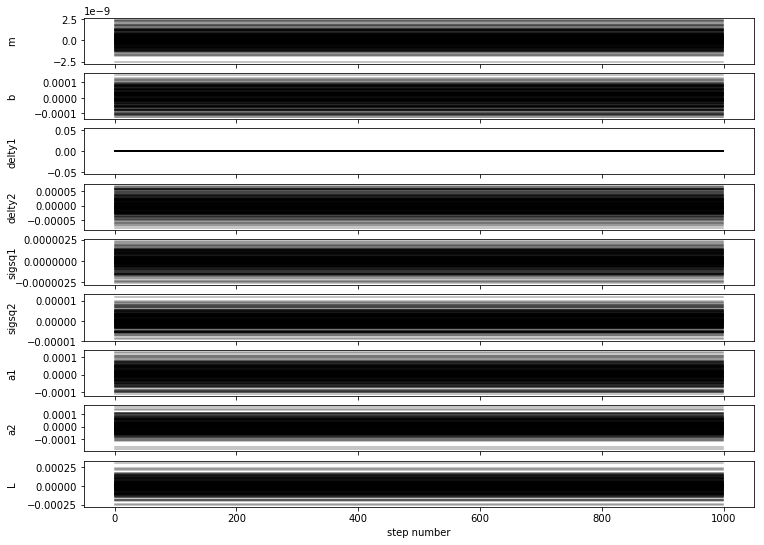

In [136]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "a2", "L"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_matrixeq22_L*2.png")
plt.show()

In [85]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

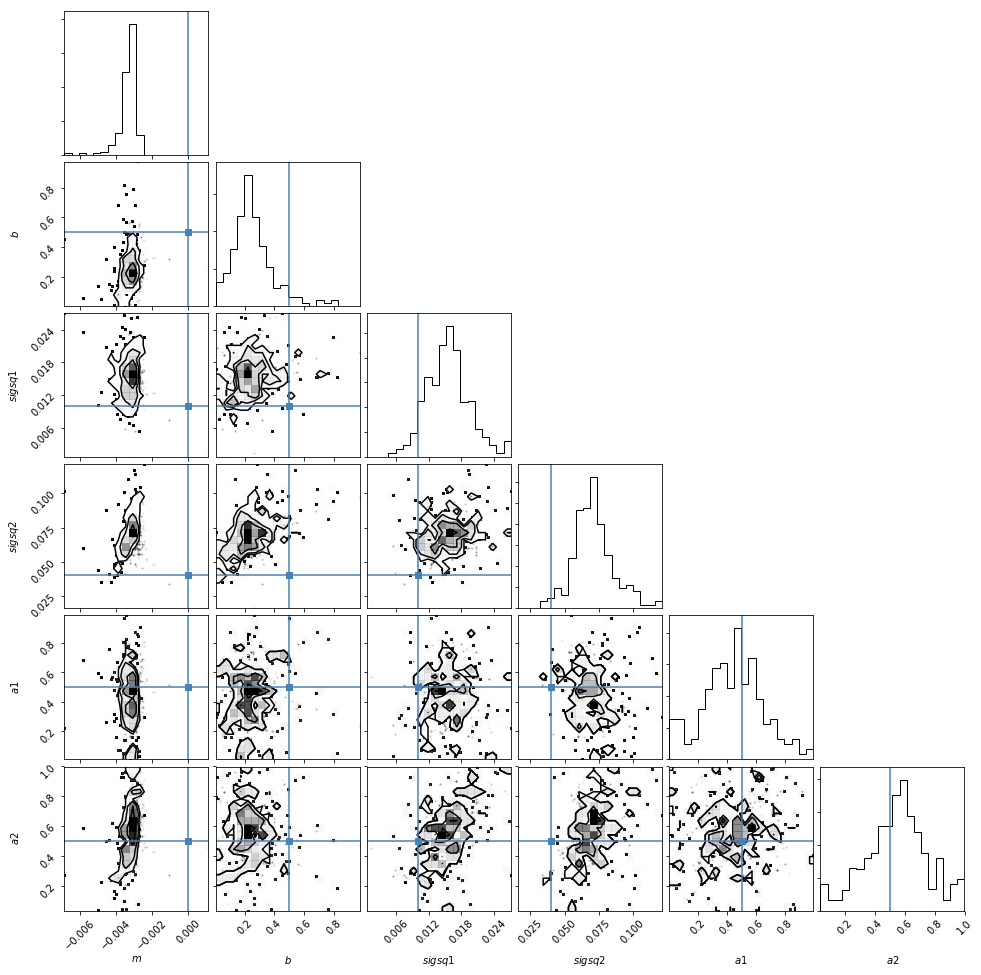

In [86]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6,7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, a2_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_matrixeq22_L*2.png")

In [87]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

-0.00322712715494 0.233275587851


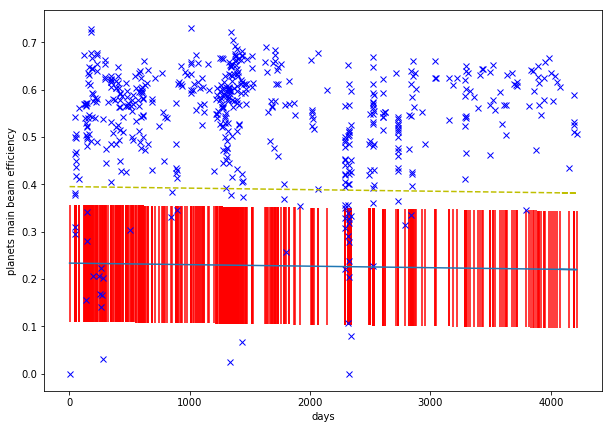

In [93]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
print(m, b)
y = m*days/1000 + b
yerr = results[4][1]
bias = results[3][1]
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.errorbar(days, y, yerr=np.sqrt(yerr), ecolor='red')
plt.plot(days, y - bias, '--', color='y')
plt.show()